* [Yelp, Not Kaggle Data Source](https://www.yelp.com/dataset/download)
* [Data Dictionary](https://www.yelp.com/dataset/documentation/main)

* [x] Get data into csv to work in pandas
* [x] Perform sentiment classification with Hugging Face model (2024 SOTA)
* [ ] Extract from text key words that resulted in sentiment class (entity-based sentiment analysis)
* [x] topic modeling
* [ ] other advanced analytics for reviews using LLM/HuggingFace
* [ ] compare competition side-by-side (Japanese restaurants)
* [ ] get criteria for ranking/qualities in restaurant based on aggregation of common words through clustering

In [1]:
!pip install duckdb jupysql -q transformers torch setfit --quiet 
!python -m spacy download en_core_web_md --quiet

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [2]:
!pip install setfit --quiet

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Data Processing
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import duckdb
%load_ext sql
conn = duckdb.connect()
%sql conn --alias duckdb

import re
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Processing and Model Inference
from nltk.corpus import stopwords
import torch
from transformers import pipeline, AutoTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer # Vader

# Topic Modeling
import spacy
nlp = spacy.load('en_core_web_md')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

Deploy Streamlit apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


2024-05-29 01:11:26.249582: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 01:11:26.249739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 01:11:26.422200: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [5]:
dfr = pd.read_csv('/kaggle/input/yelp-revised/yelp_biz_rev.csv')
dfr.head()

/tmp/ipykernel_18/3121522079.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dfr = pd.read_csv('/kaggle/input/yelp-revised/yelp_biz_rev.csv')


,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories,review_id,user_id,review_stars,text,date
0,0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",BXQcBN0iAi1lAUxibGLFzA,6_SpY41LIHZuIaiDs5FMKA,4.0,"This is nice little Chinese bakery in the heart of Philadelphia's Chinatown! The female cashier was very friendly (flirtatious!) and the pastries shown in nicely adorned display cases. I stopped by early one evening had a sesame ball, which was filled with bean paste. The glutinous rice of the ball was nicely flavored, similar to Bai Tang Gao. Definitely as place worth stopping at if you are in the area.",2014-05-26 01:09:53
1,1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",uduvUCvi9w3T2bSGivCfXg,tCXElwhzekJEH6QJe3xs7Q,4.0,"This is the bakery I usually go to in Chinatown. They have a decent variety of buns and pastries. Red bean-filled buns, mung bean-filled buns, coconut stuff, egg tarts etc. If you buy a dozen, they will give you two more for free. The prices are standard for a Chinese bakery, with most things at approximately $1. The service has always been good. They do serve coffee and tea. There are a couple of tables inside, with usually the expected group of older Chinese guys chillin' in the corner table debating about something. Great place to stock up on the buns, which I usually do before leaving town.",2013-10-05 15:19:06
2,2,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",a0vwPOqDXXZuJkbBW2356g,WqfKtI-aGMmvbA9pPUxNQQ,5.0,"A delightful find in Chinatown! Very clean, and very kind service. Everyone always seems happy in here, and their treats are absolutely delicious. You can also get a ton of sweet treats without any judgement! They're my favorite.",2013-10-25 01:34:57
3,3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",MKNp_CdR2k2202-c8GN5Dw,3-1va0IQfK-9tUMzfHWfTA,5.0,I ordered a graduation cake for my niece and 

In [6]:
dfr['categories'].value_counts()[:20]                                                                           

categories
Mexican, Restaurants                                      44958
Restaurants, Mexican                                      44000
Restaurants, Pizza                                        26614
Pizza, Restaurants                                        23189
Restaurants, Chinese                                      20683
Restaurants, Italian                                      20287
Chinese, Restaurants                                      19357
Italian, Restaurants                                      18799
Thai, Restaurants                                         13613
Seafood, Restaurants                                      11885
American (New), Restaurants                               11169
Restaurants, American (New)                               11037
Restaurants, Thai                                         10190
Cajun/Creole, Seafood, Restaurants                         9115
Restaurants, Seafood                                       8886
Vietnamese, Restaurants      

In [7]:
# Need to clean up category data

query = """
select business_id
, name
, address
, city
, state
, postal_code
, latitude
, longitude
, stars
, review_count
, attributes
, case when categories = 'Mexican, Restaurants' then 'Restaurants, Mexican'
when categories = 'Pizza, Restaurants' then 'Restaurants, Pizza'
when categories = 'Chinese, Restaurants' then 'Restaurants, Chinese'
when categories = 'Italian, Restaurants' then 'Restaurants, Italian'
when categories = 'Thai, Restaurants' then 'Restaurants, Thai'
when categories = 'Seafood, Restaurants' then 'Restaurants, Seafood'
when categories = 'American (New), Restaurants' then 'Restaurants, American (New)'
when categories = 'Thai, Restaurants' then 'Restaurants, Thai'
when categories = 'Seafood, Restaurants' then 'Restaurants, Seafood'
when categories = 'Vietnamese, Restaurants' then 'Restaurants, Vietnamese'
when categories = 'Cajun/Creole, Restaurants' then 'Restaurants, Cajun/Creole'
else categories
end as categories
, review_id
, user_id
, review_stars
, text
, date
from dfr
"""

dfr = duckdb.query(query).df()
dfr['categories'].value_counts()[:20]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

categories
Restaurants, Mexican                                                                                     88958
Restaurants, Pizza                                                                                       49803
Restaurants, Chinese                                                                                     40040
Restaurants, Italian                                                                                     39086
Restaurants, Thai                                                                                        23803
Restaurants, American (New)                                                                              22206
Restaurants, Seafood                                                                                     20771
Restaurants, Vietnamese                                                                                  15508
Restaurants, Cajun/Creole                                                                            

In [8]:
dfr['categories'].value_counts()[:20]

categories
Restaurants, Mexican                                                                                     88958
Restaurants, Pizza                                                                                       49803
Restaurants, Chinese                                                                                     40040
Restaurants, Italian                                                                                     39086
Restaurants, Thai                                                                                        23803
Restaurants, American (New)                                                                              22206
Restaurants, Seafood                                                                                     20771
Restaurants, Vietnamese                                                                                  15508
Restaurants, Cajun/Creole                                                                            

In [9]:
query = """
select review_id
, review_stars
, text
from dfr
"""

df_sent2 = duckdb.query(query).df()
df_sent2

,review_id,review_stars,text
0,BXQcBN0iAi1lAUxibGLFzA,4.0,"This is nice little Chinese bakery in the heart of Philadelphia's Chinatown! The female cashier was very friendly (flirtatious!) and the pastries shown in nicely adorned display cases. I stopped by early one evening had a sesame ball, which was filled with bean paste. The glutinous rice of the ball was nicely flavored, similar to Bai Tang Gao. Definitely as place worth stopping at if you are in the area."
1,uduvUCvi9w3T2bSGivCfXg,4.0,"This is the bakery I usually go to in Chinatown. They have a decent variety of buns and pastries. Red bean-filled buns, mung bean-filled buns, coconut stuff, egg tarts etc. If you buy a dozen, they will give you two more for free. The prices are standard for a Chinese bakery, with most things at approximately $1. The service has always been good. They do serve coffee and tea. There are a couple of tables inside, with usually the expected group of older Chinese guys chillin' in the corner table debating about something. Great place to stock up on the buns, which I usually do before leaving town."
2,a0vwPOqDXXZuJkbBW2356g,5.0,"A delightful find in Chinatown! Very clean, and very kind service. Everyone always seems happy in here, and their treats are absolutely delicious. You can also get a ton of sweet treats without any judgement! They're my favorite."
3,MKNp_CdR2k2202-c8GN5Dw,5.0,I ordered a graduation cake for my niece and it came out absolutely perfect. Will come again for future events! Staff was nice also and the cake was really good.
4,D1GisLDPe84Rrk_R4X2brQ,4.0,"HK-STYLE MILK TEA: FOUR STARS\n\nNot quite sure why there are two Saint Honore Pastries business listings on Yelp, but I have been checking in to this one.\n\nBoyfriend and I go by it all the time while in Chinatown, but it never crossed our mind to try it. I think we might have tried it once a year or two ago, but it wasn't memorable. I decided to try the HK-style milk tea not too long ago and was hooked. I think I went here almost every day one week to get the milk tea, only to realize that I should REALLY watch my sugar intake...it's sooo good! \n\nI personally don't think it's better than Zhong Gang's HK-style milk tea because they have their off days when a certain lady makes them (not enough ice, too much ice, etc.).\n\nOn a side note: I wanted to try the crispy roast pork bun, but accidentally said the wrong name in Chinese and got the roast pork bun. It was decent enough, although I will get to trying the crispy roast pork bun soon! \n\nI will be back~"
...,...,...,...
3773767,Kt3gFeW1rhZz7RuiV-6Tcw,5.0,"This is my favorite food truck! I only wish I lived closer to Philly so that I could eat here more often. The prices are affordable, the portions are generous, the staff is friendly, and the food is AMAZING. \n\nThe last time I went to the Plum Pit, I ordered a jerk chicken sandwich to split with a friend. Learn from our mistake--order your own sandwich, and if you can't finish it, save half for later. We ended up going back for another sandwich (the one with chicken tenders, mac & cheese, and bacon--I can't remember the name) anyway. We also got two orders of bread pudding to bring home, which, though pretty good cold, is ever better when you heat it up in the oven for 10-15 minutes."
3773768,ruy3Ycey_gGbwkE_3TX1Fg,5.0,"This food truck was stupid. Stupidly delicious. \n\nShould be a 4.5 because they were a little slow compared to other trucks, but once the food showed up, totally ON POINT.\n\nWe had the bacon Mac and cheese with the French fry bowl, topped with jerk chicken. I could not get enough of the jerk chicken. And the bacon Mac and cheese was super creamy ( again 4.5 we saw a big can of nacho cheese instead of good cheese "" . \n\nWould definitely eat here again if they were at the Stables."
3773769,C_l8NTpvNOEUorEmEOusaA,5.0,Bubba never disappoints i go to his fb page and hunt him down and now i have my friends and family stalking him too. One of the main r

In [10]:
# reduce file size by getting sample
#sample 500,000 to use less RAM
sample = df_sent2.sample(n=500000)
len(sample)

500000

In [11]:
sample.head(1)

,review_id,review_stars,text
1202504,PXLtWximiFglLtxulvX31Q,4.0,"Best fish tacos in town, but overall, the menu is a bit pricier than usual for Mexican. Wish the margaritas were less expensive!"


# Text Pre-Processing

In [12]:
# text column needs to be changed to string...
sample['text'] = sample['text'].apply(str)

In [13]:
# Get code to clean text of HTML tags, punctuation
def cleanhtml(x): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', x) 
    return cleantext.replace('\n\n', ' ').replace('\n', '')
    
sample['clean_text'] = sample.apply(lambda row: cleanhtml(row['text']), axis=1)

# Examine sample of dirty comments to see if translation went through
sample

,review_id,review_stars,text,clean_text
1202504,PXLtWximiFglLtxulvX31Q,4.0,"Best fish tacos in town, but overall, the menu is a bit pricier than usual for Mexican. Wish the margaritas were less expensive!","Best fish tacos in town, but overall, the menu is a bit pricier than usual for Mexican. Wish the margaritas were less expensive!"
563618,jPZadD7-0riEEb1nhiNcYA,5.0,Amazing calzones! We had quick service and really enjoyed the atmosphere as well. I'd be a regular if I lived in St. Louis!,Amazing calzones! We had quick service and really enjoyed the atmosphere as well. I'd be a regular if I lived in St. Louis!
3379417,UrwZFg0sdKYZdhTGD3_LwQ,5.0,"This is second time I have ordered from Zesto's and have been pleased both times. Ordered delivery and it was fast, well packed and warm at delivery. I first chose it because of the menu and it being family owned, will go back again!","This is second time I have ordered from Zesto's and have been pleased both times. Ordered delivery and it was fast, well packed and warm at delivery. I first chose it because of the menu and it being family owned, will go back again!"
133254,PdH-4fZ6R56IjNzIwmGgIQ,4.0,"Good spot. Has an eclectic, artsy vibe to the space. Prices comparable to other trendy shops in the area. I ventured in for quick cup of coffee to go and check out the place. Lots of space for sitting down and to hang. Around 1pm on a Monday, not crowded but certainly not empty. Always a good sign. People studying and on their laptops. Outlets and different sized work spaces throughout. Water bowl and free small dog treats at the counter. Community bike pump for free use strapped to the entrance stair rail. Cool shop. I'd def come back to for a work spot and truly explore their generous drink and food menu.","Good spot. Has an eclectic, artsy vibe to the space. Prices comparable to other trendy shops in the area. I ventured in for quick cup of coffee to go and check out the place. Lots of space for sitting down and to hang. Around 1pm on a Monday, not crowded but certainly not empty. Always a good sign. People studying and on their laptops. Outlets and different sized work spaces throughout. Water bowl and free small dog treats at the counter. Community bike pump for free use strapped to the entrance stair rail. Cool shop. I'd def come back to for a work spot and truly explore their generous drink and food menu."
2329436,78D3kYWt93Kl8KrC9D_5Lw,5.0,"We have been here for breakfast, lunch, and now dinner. I am surprised they are not busy. Maybe it's their location way in the back of the shopping center. The waitstaff is very nice, fluent in English and Spanish, and the food is really good. Huge portions. Fed us well, with leftovers for lunch tomorrow. So much better than most of the other Mexican places we have tried.","We have been here for breakfast, lunch, and now dinner. I am surprised they are not busy. Maybe it's their location way in the back of the shopping center. The waitstaff is very nice, fluent in English and Spanish, and the food is really good. Huge portions. Fed us well, with leftovers for lunch tomorrow. So much better than most of the other Mexican places we have tried."
...,...,...,...,...
1855630,w5QvQ0GNfuM3bOZeZ7iOXw,4.0,"This is a great date night spot. My boyfriend and I got the ginger salad which is a decent size and nice to split between two people as a starter. The salad was perfectly seasoned with the ginger dressing. Some other places put the ginger dressings on top and let it sit but as Zama they mix it together like a chopped salad and it was amazing. We also got the Shrimp lettuce wraps which tasted superb, but nothing to brag about.\n\nFor an entree we got the Philly cheesesteak roll and it was something like I have seen anywhere else. It is a sushi take on the cheesesteak. It is light and delicious - light compared to a cheesesteak not other sushi. It came I wrapped in a Japanese newspaper which was great touch. I really enjoyed it, but I'm not sure I would

In [14]:
# normalize text by lowering it all
sample['clean_text'] = sample['clean_text'].str.lower()

In [15]:
%%time
# Due to transformer error:
# If you are running a transformer model with HuggingFace, there is a chance that one of the input sentences is longer than 512 tokens. Either truncate or split your sentences. I suspect the shorter sentences are padded to 512 tokens.

#1. get token length/total words with max: 500 total words as max length since tokenizer can add suffixes as a token
#2. eliminate tokens lengths greater than max/summarize text using chatgpt?

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# sentence = "Sentence to check whether it exceeds 512 tokens"

# tokenized_sentence = tokenizer.tokenize(sentence)

# print(len(sentence.split()))  # here is the default length of the sentence
# print(len(tokenized_sentence)) # here is the tokenized length

## Example applied to df

sample['num_tokens_tok'] = sample.apply(lambda row: len(tokenizer.tokenize(row.clean_text)), axis = 1)
sample.head()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (659 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 5min 48s, sys: 120 ms, total: 5min 48s
Wall time: 5min 50s


,review_id,review_stars,text,clean_text,num_tokens_tok
1202504,PXLtWximiFglLtxulvX31Q,4.0,"Best fish tacos in town, but overall, the menu is a bit pricier than usual for Mexican. Wish the margaritas were less expensive!","best fish tacos in town, but overall, the menu is a bit pricier than usual for mexican. wish the margaritas were less expensive!",30
563618,jPZadD7-0riEEb1nhiNcYA,5.0,Amazing calzones! We had quick service and really enjoyed the atmosphere as well. I'd be a regular if I lived in St. Louis!,amazing calzones! we had quick service and really enjoyed the atmosphere as well. i'd be a regular if i lived in st. louis!,31
3379417,UrwZFg0sdKYZdhTGD3_LwQ,5.0,"This is second time I have ordered from Zesto's and have been pleased both times. Ordered delivery and it was fast, well packed and warm at delivery. I first chose it because of the menu and it being family owned, will go back again!","this is second time i have ordered from zesto's and have been pleased both times. ordered delivery and it was fast, well packed and warm at delivery. i first chose it because of the menu and it being family owned, will go back again!",52
133254,PdH-4fZ6R56IjNzIwmGgIQ,4.0,"Good spot. Has an eclectic, artsy vibe to the space. Prices comparable to other trendy shops in the area. I ventured in for quick cup of coffee to go and check out the place. Lots of space for sitting down and to hang. Around 1pm on a Monday, not crowded but certainly not empty. Always a good sign. People studying and on their laptops. Outlets and different sized work spaces throughout. Water bowl and free small dog treats at the counter. Community bike pump for free use strapped to the entrance stair rail. Cool shop. I'd def come back to for a work spot and truly explore their generous drink and food menu.","good spot. has an eclectic, artsy vibe to the space. prices comparable to other trendy shops in the area. i ventured in for quick cup of coffee to go and check out the place. lots of space for sitting down and to hang. around 1pm on a monday, not crowded but certainly not empty. always a good sign. people studying and on their laptops. outlets and different sized work spaces throughout. water bowl and free small dog treats at the counter. community bike pump for free use strapped to the entrance stair rail. cool shop. i'd def come back to for a work spot and truly explore their generous drink and food menu.",134
2329436,78D3kYWt93Kl8KrC9D_5Lw,5.0,"We have been here for breakfast, lunch, and now dinner. I am surprised they are not busy. Maybe it's their location way in the back of the shopping center. The waitstaff is very nice, fluent in English and Spanish, and the food is really good. Huge portions. Fed us well, with leftovers for lunch tomorrow. So much better than most of the other Mexican places we have tried.","we have been here for breakfast, lunch, and now dinner. i am surprised they are not busy. maybe it's their location way in the back of the shopping center. the waitstaff is very nice, fluent in english and spanish, and the food is really good. huge portions. fed us well, with leftovers for lunch tomorrow. so much better than most of the other mexican places we have tried.",84


In [16]:
# get rid of rows that are <450 words in length since this tokenizer is approx of tokenizer used for sentiment model
query = """
select *
from sample
where num_tokens_tok < 450
"""

sample_short_rev = duckdb.query(query).df()
sample_short_rev.head()

,review_id,review_stars,text,clean_text,num_tokens_tok
0,PXLtWximiFglLtxulvX31Q,4.0,"Best fish tacos in town, but overall, the menu is a bit pricier than usual for Mexican. Wish the margaritas were less expensive!","best fish tacos in town, but overall, the menu is a bit pricier than usual for mexican. wish the margaritas were less expensive!",30
1,jPZadD7-0riEEb1nhiNcYA,5.0,Amazing calzones! We had quick service and really enjoyed the atmosphere as well. I'd be a regular if I lived in St. Louis!,amazing calzones! we had quick service and really enjoyed the atmosphere as well. i'd be a regular if i lived in st. louis!,31
2,UrwZFg0sdKYZdhTGD3_LwQ,5.0,"This is second time I have ordered from Zesto's and have been pleased both times. Ordered delivery and it was fast, well packed and warm at delivery. I first chose it because of the menu and it being family owned, will go back again!","this is second time i have ordered from zesto's and have been pleased both times. ordered delivery and it was fast, well packed and warm at delivery. i first chose it because of the menu and it being family owned, will go back again!",52
3,PdH-4fZ6R56IjNzIwmGgIQ,4.0,"Good spot. Has an eclectic, artsy vibe to the space. Prices comparable to other trendy shops in the area. I ventured in for quick cup of coffee to go and check out the place. Lots of space for sitting down and to hang. Around 1pm on a Monday, not crowded but certainly not empty. Always a good sign. People studying and on their laptops. Outlets and different sized work spaces throughout. Water bowl and free small dog treats at the counter. Community bike pump for free use strapped to the entrance stair rail. Cool shop. I'd def come back to for a work spot and truly explore their generous drink and food menu.","good spot. has an eclectic, artsy vibe to the space. prices comparable to other trendy shops in the area. i ventured in for quick cup of coffee to go and check out the place. lots of space for sitting down and to hang. around 1pm on a monday, not crowded but certainly not empty. always a good sign. people studying and on their laptops. outlets and different sized work spaces throughout. water bowl and free small dog treats at the counter. community bike pump for free use strapped to the entrance stair rail. cool shop. i'd def come back to for a work spot and truly explore their generous drink and food menu.",134
4,78D3kYWt93Kl8KrC9D_5Lw,5.0,"We have been here for breakfast, lunch, and now dinner. I am surprised they are not busy. Maybe it's their location way in the back of the shopping center. The waitstaff is very nice, fluent in English and Spanish, and the food is really good. Huge portions. Fed us well, with leftovers for lunch tomorrow. So much better than most of the other Mexican places we have tried.","we have been here for breakfast, lunch, and now dinner. i am surprised they are not busy. maybe it's their location way in the back of the shopping center. the waitstaff is very nice, fluent in english and spanish, and the food is really good. huge portions. fed us well, with leftovers for lunch tomorrow. so much better than most of the other mexican places we have tried.",84


In [17]:
#Check max number tokens
query = """
select max(num_tokens_tok) as max_tokens
from sample_short_rev
"""

duckdb.query(query).df()

,max_tokens
0,449


In [18]:
# remaining of sample after token length filter
len(sample_short_rev)

489113

# Sentiment Classification

In [19]:
# using Hugging Face sentiment classifier trained on Yelp restaurant reviews

# Set up the inference pipeline using a model from the 🤗 Hub

sentiment_analysis = pipeline(model="mrcaelumn/yelp_restaurant_review_sentiment_analysis")

config.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [20]:
test = sample_short_rev.sample(n=5000)

In [21]:
%%time

test = (
test.assign(sentiment = lambda x: x['clean_text'].apply(lambda s: sentiment_analysis(s)))
    .assign(
         label = lambda x: x['sentiment'].apply(lambda s: (s[0]['label'])),
         score = lambda x: x['sentiment'].apply(lambda s: (s[0]['score']))
    )
)

test.head()

CPU times: user 20min 17s, sys: 2.25 s, total: 20min 19s
Wall time: 10min 10s


,review_id,review_stars,text,clean_text,num_tokens_tok,sentiment,label,score
9251,A4ySY2Ui8Dul3pGnr83Igw,5.0,"This place is AMAZING. The staff is so kind, friendly and enjoyable and the FOOD is out of this world! You are in for a treat if you dine here. Their take out is also excellent!","this place is amazing. the staff is so kind, friendly and enjoyable and the food is out of this world! you are in for a treat if you dine here. their take out is also excellent!",42,"[{'label': 'LABEL_2', 'score': 0.9984384179115295}]",LABEL_2,0.998438
32564,rf0ftC3V0ba8aRteqKYXjA,4.0,"Pleasantly surprised. I tend to order from same places bc what's worse than paying for mediocre food? My boyfriend finally convinced me one day to step out of my comfort zone and we settled on Speedy's. We each got a cheesesteak and also a small pepperoni. The cheesesteaks were REALLY good. Not the absolute best but GOOD, and dare I say the best for this area (greater Northeast). Meat, cheese, bread ratio was on point. Flavoring was good. Portion size was just right, thick enough to fill you up but not to the point the sandwich was sloppy with meat flying everywhere. I will def get a cheesesteak from here again. As for the pizza, I took a few bites and it just didn't do it for me. My boyfriend said it was ok but I'm a self proclaimed pizza snob so I was disappointed. I may say screw it though and give their pizza another try. Oh and the name fits them well. Our food was ready for pickup in 15 minutes. That means a lot during the lunch rush. A lot of places will tell you a time and then have you waiting around like you don't have to get back to work, not the case with this joint. I will be back for more.","pleasantly surprised. i tend to order from same places bc what's worse than paying for mediocre food? my boyfriend finally convinced me one day to step out of my comfort zone and we settled on speedy's. we each got a cheesesteak and also a small pepperoni. the cheesesteaks were really good. not the absolute best but good, and dare i say the best for this area (greater northeast). meat, cheese, bread ratio was on point. flavoring was good. portion size was just right, thick enough to fill you up but not to the point the sandwich was sloppy with meat flying everywhere. i will def get a cheesesteak from here again. as for the pizza, i took a few bites and it just didn't do it for me. my boyfriend said it was ok but i'm a self proclaimed pizza snob so i was disappointed. i may say screw it though and give their pizza another try. oh and the name fits them well. our food was ready for pickup in 15 minutes. that means a lot during the lunch rush. a lot of places will tell you a time and then have you waiting around like you don't have to get back to work, not the case with this joint. i will be back for more.",264,"[{'label': 'LABEL_2', 'score': 0.9024320840835571}]",LABEL_2,0.902432
245251,SQKsgaWijRlHD4CoAiQJlw,2.0,"Only 2 stars because the entire place looked and felt dirty. Table and booths were greasy. Bathroom was gross. Waiters, hostess and chefs were loudly yelling at and fighting with each other, repeatedly. I only had a sundae, and it was delicious, but took 15 minutes. It also seemed small and expensive. The dish was no where near as full as the menu picture. I have had many sundaes at local establishments, and this was by far the least ice cream for the most money. But, again, it was delicious. Server was very nice. I would only return to get ice cream from the take out window. Their WiFi is free but pathetically slow.","only 2 stars because the entire place looked and felt dirty. table and booths were greasy. bathroom was gross. waiters, hostess and chefs were loudly yelling at and fighting with each other, repeatedly. i only had a sundae, and it was delicious, but took 15 minutes. it also seemed small and expensive. the dish was no where near as full as the menu picture. i have had many sundaes at local establishments, and this was by far the least ice

In [22]:
# Sentiment Label Breakdown
test['label'].value_counts() # Mostly positive reviews

label
LABEL_2    3516
LABEL_0     975
LABEL_1     509
Name: count, dtype: int64

In [23]:
# LABEL_0 only

query = """
select clean_text
, review_stars
, label
, score
from test
where label = 'LABEL_0'
"""

label_0 = duckdb.query(query).df()
label_0.head()

,clean_text,review_stars,label,score
0,"only 2 stars because the entire place looked and felt dirty. table and booths were greasy. bathroom was gross. waiters, hostess and chefs were loudly yelling at and fighting with each other, repeatedly. i only had a sundae, and it was delicious, but took 15 minutes. it also seemed small and expensive. the dish was no where near as full as the menu picture. i have had many sundaes at local establishments, and this was by far the least ice cream for the most money. but, again, it was delicious. server was very nice. i would only return to get ice cream from the take out window. their wifi is free but pathetically slow.",2.0,LABEL_0,0.510352
1,there was a rodent running across the floor as we ate.. i am sure other places have this however seeing it just made it worse ... sorry ihop,2.0,LABEL_0,0.978570
2,this is the dirtiest saint louis bread / panera i've visited. all the tables we attempted to sit on were dirty. they got the order wrong (which is becoming too common at several panera's in the past couple of years),1.0,LABEL_0,0.986265
3,i didn't want to give them a rating as their service is clearly not worthy of even a 1 but you can't post a review without giving one. my friend and her fiancé recently went there and was discriminated against because they are african american. the owner even called the cops on them and made a false claim of fear based on their race. i would never patronize this establishment and hope that no one spends their hard earned money at a place who thinks nothing of treating others this way.,1.0,LABEL_0,0.982285
4,false advertising on menus . stated this was $3.50 for each taco and was overcharged and told this price is not valid because it's not tuesday. however they advertise this as $3.50. i hate that,1.0,LABEL_0,0.985204


In [24]:
label_0['review_stars'].value_counts() #for lowest star ratings/negative sentiment

review_stars
1.0    575
2.0    270
3.0    108
4.0     17
5.0      5
Name: count, dtype: int64

In [25]:
# Curious about possible mislabeling, what are the reviews acually reading as. was user accurate in their star rating or sentiment model wrong?
query = """
select clean_text
, review_stars
, label
, score
from label_0
where review_stars >=4
"""

bad_labels_0 = duckdb.query(query).df()
bad_labels_0

,clean_text,review_stars,label,score
0,do not get the flat pizza. only get the pan pizza. it's 100x better than the flat. we accidentally ordered the flat and cried over us missing the deep dish!,5.0,LABEL_0,0.933244
1,"i've been there a few times, and each time the service has been pretty brutal. i can sit there for ages as the waitresses mill about one of the booths socializing, trying to catch their eye to get what i need. the beef vermicelli bowl is fantastic and i ccould eat it over and over again. today i tried to order something different and i regret it pretty badly. i ordered the beef satay pho, and the broth was way way too thick. it was more like peanut dipping sauce that had been slightly watered down and added to noodles. i couldn't eat it, i left most of it behind and ended up ordering a vermicelli bowl to take away. beef vermicelli bowl was $12 and satay pho was $11. not bad price but was super disappointed by the satay pho.",4.0,LABEL_0,0.686076
2,my server eric truong was the worst server i ever had!he was sooo cute i couldn't stop looking at him. every time he walked by he smelled like flowers and my head would flutter. come visit umi 2 for this handsome goddess,5.0,LABEL_0,0.971602
3,"come to french quarter many times as i live in biloxi ms. in bar area and they have 2 servers, one for drinks and one for food. the black dude who served drinks was extremely good server and friendly . emily was terrible server with no personality and very unfriendly. expectedly, she smiles when she brought the check. waited tables, owned a restaurant and managed one as well. it was clear and wonder how she got hired. probably her looks. she will soon discover that doesn't work in a fine dining establishment.",4.0,LABEL_0,0.754713
4,"i really wanted to give this place 5 stars.... in the end, i just couldn't do it. i got the cuban sandwich and the wife an omelette. the sandwich was lacking in pork. the bread pudding came out cold. i must say that there is significant value here. you get in and out quick and for a low price.",4.0,LABEL_0,0.529544
5,"got take out from here and the reviews from the crew were mixed. my focus was on the pastrami sandwich. the pastrami was wonderfully smoky but lacked the spicy flavors of aggressive coriander and black pepper. the sandwich was topped with not enough cheese plus onion which was barely sautéed. the pulled pork sandwich was probably the best thing we ate but was a bit dry, that is we would have liked a bit more sauce. the smoked chicken wings were tender and smoky but again the rub just wasn't assertive enough for me we had two pastrami sandwiches, the pulled pork, and six wings. all of this came with 3 very small containers-one with thousand island dressing, one with barbeque sauce and one with a third unidentified sauce. not enough sauces for what we ordered. service was marginally polite.",4.0,LABEL_0,0.606179
6,ordered a seafood platter for me and my wife - have mercy - delish but no way we could eat all that food,5.0,LABEL_0,0.890069
7,"bakery: the lady at the bakery is the rudest and most negative person i've encountered in indy. asking for samples of ice cream was like pulling teeth with her. while we waited we looked in the bakery cases and saw flies trapped inside. disgusting. grocery: great prices, full service butcher shop. restaurant: cheap, authentic, and delicious!",4.0,LABEL_0,0.983788
8,"the hole in the way kind of restaurant. my wife, friends and i came in and they said we can seat anywhere. the server came gave us each a menu and ask what we want to drink. a few minutes she took down our order. i got the burger called go big ""bleu"" burger. the burger have blue cheese in it. it taste really good but the down side is the grease was dripping out of the burger. when we almost done eating the waitress gave us our check and refill of our drinks in a togo cup.",4.0,LABEL_0,0.719448
9,"the consistency of omelettes in good diners is astounding. i've had the same western omelet

# labeling check (sampled 6)
1. incorrect rating from model - 5 (0,1,3,4,5)
2. incorrect star rating from user - 1 (2)

In [26]:
bad_labels_0['score'].describe()

count    22.000000
mean      0.749280
std       0.144505
min       0.529544
25%       0.619247
50%       0.738248
75%       0.877852
max       0.983788
Name: score, dtype: float64

In [27]:
print('Percentage of bad labels in negative sentiment class:',round(len(bad_labels_0)/len(label_0),2) *100, '%.')

Percentage of bad labels in negative sentiment class: 2.0 %.


In [28]:
# LABEL_1 only

query = """
select clean_text
, review_stars
, label
, score
from test
where label = 'LABEL_1'
"""

label_1 = duckdb.query(query).df()
label_1.head()

,clean_text,review_stars,label,score
0,"this place is just ok. the staff aren't overly friendly and the food is just mediocre. i live right down the street so it is convenient to grab an egg sandwich, but it's nothing that i couldn't make myself at home. the potatoes aren't seasoned enough and the bacon is kind of floppy. i guess you get what you pay for.",3.0,LABEL_1,0.803596
1,the tea/drinks here are pretty good. comparable to some of my favorites back in ca! the food here on the other hand is pretty mediocre. i've tried a handful of things here and they've all just been ok. but definitely would come here for the drinks.,4.0,LABEL_1,0.896761
2,"i was expecting something that would be pretty decent when i was paying $8 for a burger, taking into account that it does not come with any sides. but the first sign that i knew it wasnt going to be particularly good was that the lamb burger, despite being lamb, was cheaper than most other burgers on the menu... while the burger was hot and fresh, it took a little while to come out yet it still looked like it was simply slapped together. the toppings were scarce and only in the center of the burger, leaving half of it with just lamb patty and bun. the burger in general was simply not tasty despite the delicious sounding ingredients. overall, i might consider eating here again because of their interesting items and variety; however, if i'm looking for a burger, i would much rather go to the habit or any other burger joint even if its further away, simply because they're all either cheaper, better in quality, or both.",2.0,LABEL_1,0.608676
3,below averse tasting mexico food. menu was somewhat limited. service was fast and friendly and prices are inexpensive.,2.0,LABEL_1,0.631101
4,there were not a lot of options in ballpark village on new years day. we were trying to have lunch with my wife's sister who suggested we go here. we had trashed wings as a starter. i thought they might have all kinds of toppings. they were pretty normal except they were smoked and flash fried naked. this is my favorite way to eat wings so i was very happy. the hot sauce had a unique flavor but was only moderately hot. i would definitely get these again if i went back. we both decided on the burnt ends sandwich with beef fat fries. the burnt ends were cooked perfectly. a nice bark on the outside but tender and moist inside. the only reason for 4 stars was that the server wasn't very attentive. there were very few people there and our drinks were often empty i do not remember her ever asking how are meal was.,4.0,LABEL_1,0.750700


In [29]:
label_1['review_stars'].value_counts() #suppose to be for neutral. makes sense that 1 and 5 are on the bottom

review_stars
3.0    264
4.0    114
2.0     99
1.0     18
5.0     14
Name: count, dtype: int64

In [30]:
# Curious about possible mislabeling, what are the reviews acually reading as. was user accurate in their star rating or sentiment model wrong?
query = """
select clean_text
, review_stars
, label
, score
from label_1
where review_stars in (1,5)
"""

bad_labels_1 = duckdb.query(query).df()
bad_labels_1

,clean_text,review_stars,label,score
0,"good food the carnitas are great, but the lady with short hair at the cash register is rude and has a bad attitude, will not come back because of her.",1.0,LABEL_1,0.504382
1,"my friend and i want, and it wasn't bad it was cute, and everyone was friendly, but the food wasn't the best, and the milkshakes were okay",1.0,LABEL_1,0.900614
2,"i can't believe the owner's response to what appears to be a joking comment by el jay.he hates yelp or hates freedom of expression. he would be better off business wise, to minimize his own interaction with costumers on here. when you run a business you don't behave that way,, esp when it's in writing and she obviously copy, cut, and pasted it. i've been to this place twice per week since it opened and bought clothing and stuff and coffee and tea and it's good but there is a hint of weirdness but so does ybor. i like it. however, this place is struggling and is not so busy and needs all the customers it can get so advice to owner is keep your pie hole shut and resist the urge to be a d-bag on here or to any criticism of your business. run your business and put up with it. resist the temptation to respond to this.",1.0,LABEL_1,0.603340
3,"the friday family joke has become: what food will we get today? the last dozen times we've gone through the drive through the food order hasn't been right. today we ordered two chicken plank meals, and got all fish. we also ordered three tacos, and got one taco and a chalupa. all of our iced teas were pepsi. i mean, let's review. fish is diamond shaped, chicken is a plank. iced tea does not start with the letter ""p"". it's not that hard. the receipts are always right, but the food never matches the receipt. we keep hoping it will get better because it's the closest ljs. but, my sense is if i want chicken i'll have to go across the street to popeye's.",1.0,LABEL_1,0.679902
4,"i like the food here, it's a little over-priced for what it is, but most breakfast places are. my problem is that they were super sneaky about the pre-added gratuity to the bill. i wrote this so ppl can be on the look out. we had 5 ppl in our party, 3 adults, 2 kids so i wasn't looking out for it. we got our bill and it seemed off to me. i had left $14 on the table while i went to pay the $70 bill. i kept telling the cashier the bill didn't seem right and nothing was market on the hand written ticket. i pulled out a menu and the calculator for my phone and showed here where it didn't add up unless the tax was around 30%. she then told me about the gratuity. i don't mind gratuity, but i have never had a place go so far out of their way to cover it up. i went and got my $14 back. i loved this place but i don't like being played like that, so i will not be back. i had been there about 6 times and frequently took visiting family and friends there.",1.0,LABEL_1,0.530169
5,nice diner. good food and excellent service i sit at the counter occasionally and listen to this hostess/ owner? small thin lady with a nasty attitude toward her staff. she appears to be an owner. shame in her. i don't have to spend my money and listen to this biatch!,1.0,LABEL_1,0.454781
6,"what a fun, delicious-looking restaurant. and as long as you don't go through the drive-through, you'll be able to enjoy their food. my group of four stopped by to try their food for the first time. we were handed our shakes and a large sack of food. time to hit the open road and enjoy some steak & shake. as we passed out booty the harsh reality set in of our predicament began to set. the driver was missing his burger. his wingman was missing his fries. my backseat cohort had the wrong sandwich and was missing all the dipping sauce to boot. and then there was me. the guy paying for the meal who decided to eat healthy. i stared at my salad trough the plastic lid. it was covered in sour cream and looked somewhat appealing, but since i was not given a fork i was left with two options. option 1. attempt

# labeling check (sampled 6) 
1. incorrect rating from model - 6 (0,1,2,3,4,5)
2. incorrect star rating from user - 

In [31]:
bad_labels_1['score'].describe()

count    32.000000
mean      0.609403
std       0.120450
min       0.422623
25%       0.520939
50%       0.614402
75%       0.681231
max       0.900614
Name: score, dtype: float64

In [32]:
print('Percentage of bad labels in neutral sentiment class:',round(len(bad_labels_1)/len(label_1),2) *100, '%.')

Percentage of bad labels in neutral sentiment class: 6.0 %.


In [33]:
# LABEL_2 only

query = """
select clean_text
, review_stars
, label
, score
from test
where label = 'LABEL_2'
"""

label_2 = duckdb.query(query).df()
label_2.head()

,clean_text,review_stars,label,score
0,"this place is amazing. the staff is so kind, friendly and enjoyable and the food is out of this world! you are in for a treat if you dine here. their take out is also excellent!",5.0,LABEL_2,0.998438
1,"pleasantly surprised. i tend to order from same places bc what's worse than paying for mediocre food? my boyfriend finally convinced me one day to step out of my comfort zone and we settled on speedy's. we each got a cheesesteak and also a small pepperoni. the cheesesteaks were really good. not the absolute best but good, and dare i say the best for this area (greater northeast). meat, cheese, bread ratio was on point. flavoring was good. portion size was just right, thick enough to fill you up but not to the point the sandwich was sloppy with meat flying everywhere. i will def get a cheesesteak from here again. as for the pizza, i took a few bites and it just didn't do it for me. my boyfriend said it was ok but i'm a self proclaimed pizza snob so i was disappointed. i may say screw it though and give their pizza another try. oh and the name fits them well. our food was ready for pickup in 15 minutes. that means a lot during the lunch rush. a lot of places will tell you a time and then have you waiting around like you don't have to get back to work, not the case with this joint. i will be back for more.",4.0,LABEL_2,0.902432
2,"outstanding all the way around. brand new building and top notch atmosphere. clean, updated menu. can't say enough great things about this particular tgi fridays.",5.0,LABEL_2,0.998070
3,"absolutely delicious. zin burger with a truffle aioli, sweet potato fries - must try. and a glass of cabernet sauvignon, what can be a better treat after busy monday? highly recommend this place. food was fantastic, so was my server olivia",5.0,LABEL_2,0.998050
4,"this was the best italian i've had in reno, and the closest thing to italian-style and tasting food i've had since being in italy. all of the pastas are hand-made. i got the duck ragout special and it was nothing short of phenomenal. i will definitely be back. the atmosphere is simple and open, and the food was just delectable. i can't wait to try more!",5.0,LABEL_2,0.998145


In [34]:
label_2['review_stars'].value_counts() # suppose to be for highly positive

review_stars
5.0    2314
4.0    1056
3.0     134
2.0       7
1.0       5
Name: count, dtype: int64

In [35]:
# Curious about possible mislabeling, what are the reviews acually reading as. was user accurate in their star rating or sentiment model wrong?
query = """
select clean_text
, review_stars
, label
, score
from label_2
where review_stars in (1,2)
"""

bad_labels_2 = duckdb.query(query).df()
bad_labels_2

,clean_text,review_stars,label,score
0,"ken's seafood is a great place if you would like your 9pm reservation ignored, constantly being assured by owner ""10 more minutes, i promise"" and then finally getting a room @ 10:30pm, being served watered down alcohol,and having to endure other patrons smoking when a smoking ban is in effect. *drum roll please* and the top reason some may love coming here-- to be constantly groped and molested by the skeevy, drunk, married owner. all this made for a very interesting night and i am sure you too can have the whole ken's seafood experience--but be sure to put in your reservations early! (i mean it, make the reservations early and then get there 2 hours later, i'm sure good 'ol ken will still make you wait with sweet promises too!)(the g-rated version) at the end of our ""adventurous"" night, someone finally spoke up (you know who you are & thank you!) after ken tried to work his magic on her, but she clearly told him we all obviously were skeeved out since the multiple times he came into our private room, we would all huddle together in 1 corner. he looked confused and ironically drunk off his watered down drinks & made a pathetic apology. he then stormed off, but his cheap hollow door wouldn't give him the effect he was trying for. but then he showed us by giving us our bill with our original total crossed off & adding an extra $20 to it. we decided not to leave a tip since we figured he tried to have his way with all of us (he doesn't discriminate either) so that was a big tip in itself. apparently, these smooth cat moves may have worked in the past for him, so i guess we ""missed out"".but don't let any of this deter you from trying this place out. just don't forget to bring your mace. and eat ahead of time.",1.0,LABEL_2,0.618579
1,"going to dave & buster's is like having sex with a prostitute. it seems like a good idea when your drunk, and you get to do a bunch of stuff that you can't do at home... but after all the funs over, its there. its in you... aids. not hiv, full-blown aids.",1.0,LABEL_2,0.592943
2,"usually my favorite pizza, buuuut not today when i bit into my awesome slice of heaven only to discover someone's hair!! yep .. baked right in. yuck!! bon-appetite!",1.0,LABEL_2,0.994842
3,"loved the music but count your change if cody is at the bar. gave him $20 and got change for $10. great way to rip off tourists, eh?",2.0,LABEL_2,0.948528
4,"pretty much "" the place"" to bring tourist or relatives visiting tampa. much better places for spanish food around town. the salad and the building itself are the best things going here!",2.0,LABEL_2,0.951863
5,we ordered takeout from neshaminy mall. my son loves the southwestern chicken tacos....otherwise i would never order takeout. i always ask for the spicy sauce on the side. the kitchen always puts it on. i check it now before leaving. usually it's on there and i have to wait longer to get it remade. i looked at my receipt when i got home and noticed 1.39 packaging fee. i wasn't aware they were now charging a packaging fee.,2.0,LABEL_2,0.672081
6,"adhere to your hours listed, we set aside a time to come when your hours show you are open and of course, you are closed!",1.0,LABEL_2,0.978956
7,"gave this place a 3rd try and yet again they got my order wrong. i specifically made myself abundantly clear being as nice as possible when placing my order. only to get there and find that the very thing she asked me if i wanted and repeatedly told her no, was put on my pizza. i can understand if it happened once but dang three times, three different mistakes! the guy did ask if i wanted to wait that he would make me another one but i didn't have time that was the point in calling ahead. anyway i appreciate that he offered. dunedin location which i normally drive to even though it'a out of my way, are nice and always gets it right!",1.0,LABEL_2,0.901894
8,"dude mis-gendered my girlfriend which was fine, happens, but then he was rude when we aske

# labeling check (sampled 6) 
1. incorrect rating from model - 6 (0,1,2,3,4,5)
2. incorrect star rating from user - 

In [36]:
bad_labels_2['score'].describe() # lower percentage the better since these not good labels from model

count    12.000000
mean      0.803205
std       0.149861
min       0.592943
25%       0.682235
50%       0.790707
75%       0.949361
max       0.994842
Name: score, dtype: float64

In [37]:
print('Percentage of bad labels in positive sentiment class:',round(len(bad_labels_2)/len(label_2),2) *100, '%.')

Percentage of bad labels in positive sentiment class: 0.0 %.


Hugging Face Model was still confident in some really bad/really good sentiment reviews,but only <5% for each sentiment class.

## Continuing to work with 'test" dataset (5,000 samples) due to limited CPU

In [38]:
# Changing sentiment labels to ones that make more sense
query = """
select review_id
, review_stars
, clean_text
, case when label = 'LABEL_0' then 'negative'
when label = 'LABEL_1' then 'neutral'
else 'positive'
end as hf_sent_label
, score as hf_sent_score
from test

"""

test2 = duckdb.query(query).df()
test2

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score
0,A4ySY2Ui8Dul3pGnr83Igw,5.0,"this place is amazing. the staff is so kind, friendly and enjoyable and the food is out of this world! you are in for a treat if you dine here. their take out is also excellent!",positive,0.998438
1,rf0ftC3V0ba8aRteqKYXjA,4.0,"pleasantly surprised. i tend to order from same places bc what's worse than paying for mediocre food? my boyfriend finally convinced me one day to step out of my comfort zone and we settled on speedy's. we each got a cheesesteak and also a small pepperoni. the cheesesteaks were really good. not the absolute best but good, and dare i say the best for this area (greater northeast). meat, cheese, bread ratio was on point. flavoring was good. portion size was just right, thick enough to fill you up but not to the point the sandwich was sloppy with meat flying everywhere. i will def get a cheesesteak from here again. as for the pizza, i took a few bites and it just didn't do it for me. my boyfriend said it was ok but i'm a self proclaimed pizza snob so i was disappointed. i may say screw it though and give their pizza another try. oh and the name fits them well. our food was ready for pickup in 15 minutes. that means a lot during the lunch rush. a lot of places will tell you a time and then have you waiting around like you don't have to get back to work, not the case with this joint. i will be back for more.",positive,0.902432
2,SQKsgaWijRlHD4CoAiQJlw,2.0,"only 2 stars because the entire place looked and felt dirty. table and booths were greasy. bathroom was gross. waiters, hostess and chefs were loudly yelling at and fighting with each other, repeatedly. i only had a sundae, and it was delicious, but took 15 minutes. it also seemed small and expensive. the dish was no where near as full as the menu picture. i have had many sundaes at local establishments, and this was by far the least ice cream for the most money. but, again, it was delicious. server was very nice. i would only return to get ice cream from the take out window. their wifi is free but pathetically slow.",negative,0.510352
3,uS2Pk2VXbLg0-BEGp2MLTw,5.0,"outstanding all the way around. brand new building and top notch atmosphere. clean, updated menu. can't say enough great things about this particular tgi fridays.",positive,0.998070
4,m66W1moPqY_elklnZ4P2gA,5.0,"absolutely delicious. zin burger with a truffle aioli, sweet potato fries - must try. and a glass of cabernet sauvignon, what can be a better treat after busy monday? highly recommend this place. food was fantastic, so was my server olivia",positive,0.998050
...,...,...,...,...,...
4995,UvkbJlSasiC9PlI3KLmCCQ,4.0,"i tried the avocado salad with added chicken. very good! it could have used a bit more chicken, but it was absolutely delicious! ordering was quick and service was prompt. recommended and i will be back.",positive,0.995358
4996,QHO4l82Gn2zFOKMyHf2MAQ,2.0,"was here today for breakfast for my first time. it wasn't crowded but it took just about 30 minutes to receive my food. my ham and cheese omelet was watery and tasteless. the reason for 2 stars and not just one, because my girlfriends breakfast was tasty. she had the stuffed french toast. all in all i don't think the staff has it down. i felt it was being ran as if it was their first day opened. check out the bacon strip on the floor for those still hungry...",negative,0.721379
4997,ttzdgi4ErFnH2NWMtZ9nEg,4.0,"i checked "" yes"" in good for kids, and i would say there are definitely some options that my daugther would eat. she really loved the asparagus soup served that day. for infants... not so much, my son spent his time in the car seat in the floor so i would think some more highchairs would be helpful. the day we went was pretty busy, but the servers were helpful and timely. overall a very good experience and a most welcome addition for us long time nashville vegetarians!",positive,0.992306
4998,7ifnE6vAVZwx-mNuFl2nvA,3.0,"parking 

### Checking to see if Vader sentiment classification is better than Hugging Face's predictions

In [39]:
# Let's see if Vader, popular sentiment score for social texts (tweets with emojoi's, slang, contractions) performs better than Hugging Face's scores
analyzer = SentimentIntensityAnalyzer()
test2['vader_rating'] = test2['clean_text'].apply(analyzer.polarity_scores)

# Docs on how scoring was derived and what it means: https://github.com/cjhutto/vaderSentiment#about-the-scoring
# positive sentiment: compound score >= 0.05
# neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
# negative sentiment: compound score <= -0.05
test2['compound'] = [analyzer.polarity_scores(x)['compound'] for x in test2['clean_text']]
test2['neg'] = [analyzer.polarity_scores(x)['neg'] for x in test2['clean_text']]
test2['neu'] = [analyzer.polarity_scores(x)['neu'] for x in test2['clean_text']]
test2['pos'] = [analyzer.polarity_scores(x)['pos'] for x in test2['clean_text']]

In [40]:
test2.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos
0,A4ySY2Ui8Dul3pGnr83Igw,5.0,"this place is amazing. the staff is so kind, friendly and enjoyable and the food is out of this world! you are in for a treat if you dine here. their take out is also excellent!",positive,0.998438,"{'neg': 0.0, 'neu': 0.574, 'pos': 0.426, 'compound': 0.9703}",0.9703,0.000,0.574,0.426
1,rf0ftC3V0ba8aRteqKYXjA,4.0,"pleasantly surprised. i tend to order from same places bc what's worse than paying for mediocre food? my boyfriend finally convinced me one day to step out of my comfort zone and we settled on speedy's. we each got a cheesesteak and also a small pepperoni. the cheesesteaks were really good. not the absolute best but good, and dare i say the best for this area (greater northeast). meat, cheese, bread ratio was on point. flavoring was good. portion size was just right, thick enough to fill you up but not to the point the sandwich was sloppy with meat flying everywhere. i will def get a cheesesteak from here again. as for the pizza, i took a few bites and it just didn't do it for me. my boyfriend said it was ok but i'm a self proclaimed pizza snob so i was disappointed. i may say screw it though and give their pizza another try. oh and the name fits them well. our food was ready for pickup in 15 minutes. that means a lot during the lunch rush. a lot of places will tell you a time and then have you waiting around like you don't have to get back to work, not the case with this joint. i will be back for more.",positive,0.902432,"{'neg': 0.081, 'neu': 0.792, 'pos': 0.127, 'compound': 0.8304}",0.8304,0.081,0.792,0.127
2,SQKsgaWijRlHD4CoAiQJlw,2.0,"only 2 stars because the entire place looked and felt dirty. table and booths were greasy. bathroom was gross. waiters, hostess and chefs were loudly yelling at and fighting with each other, repeatedly. i only had a sundae, and it was delicious, but took 15 minutes. it also seemed small and expensive. the dish was no where near as full as the menu picture. i have had many sundaes at local establishments, and this was by far the least ice cream for the most money. but, again, it was delicious. server was very nice. i would only return to get ice cream from the take out window. their wifi is free but pathetically slow.",negative,0.510352,"{'neg': 0.096, 'neu': 0.78, 'pos': 0.125, 'compound': 0.7743}",0.7743,0.096,0.780,0.125
3,uS2Pk2VXbLg0-BEGp2MLTw,5.0,"outstanding all the way around. brand new building and top notch atmosphere. clean, updated menu. can't say enough great things about this particular tgi fridays.",positive,0.998070,"{'neg': 0.1, 'neu': 0.64, 'pos': 0.259, 'compound': 0.6377}",0.6377,0.100,0.640,0.259
4,m66W1moPqY_elklnZ4P2gA,5.0,"absolutely delicious. zin burger with a truffle aioli, sweet potato fries - must try. and a glass of cabernet sauvignon, what can be a better treat after busy monday? highly recommend this place. food was fantastic, so was my server olivia",positive,0.998050,"{'neg': 0.0, 'neu': 0.62, 'pos': 0.38, 'compound': 0.9583}",0.9583,0.000,0.620,0.380


In [41]:
# Get vader sentiment in neat format

query = """
select review_id
, review_stars
, clean_text
, hf_sent_label
, hf_sent_score

, case when compound <= -0.05 then 'negative'
when compound > -0.05 and compound <0.05 then 'neutral'
else 'positive'
end as vader_sent_label
, compound as vader_score

, neg as text_neg_ratio
, neu as text_neu_ratio
, pos as text_pos_ratio
from test2
"""

test3 = duckdb.query(query).df()
test3

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_sent_label,vader_score,text_neg_ratio,text_neu_ratio,text_pos_ratio
0,A4ySY2Ui8Dul3pGnr83Igw,5.0,"this place is amazing. the staff is so kind, friendly and enjoyable and the food is out of this world! you are in for a treat if you dine here. their take out is also excellent!",positive,0.998438,positive,0.9703,0.000,0.574,0.426
1,rf0ftC3V0ba8aRteqKYXjA,4.0,"pleasantly surprised. i tend to order from same places bc what's worse than paying for mediocre food? my boyfriend finally convinced me one day to step out of my comfort zone and we settled on speedy's. we each got a cheesesteak and also a small pepperoni. the cheesesteaks were really good. not the absolute best but good, and dare i say the best for this area (greater northeast). meat, cheese, bread ratio was on point. flavoring was good. portion size was just right, thick enough to fill you up but not to the point the sandwich was sloppy with meat flying everywhere. i will def get a cheesesteak from here again. as for the pizza, i took a few bites and it just didn't do it for me. my boyfriend said it was ok but i'm a self proclaimed pizza snob so i was disappointed. i may say screw it though and give their pizza another try. oh and the name fits them well. our food was ready for pickup in 15 minutes. that means a lot during the lunch rush. a lot of places will tell you a time and then have you waiting around like you don't have to get back to work, not the case with this joint. i will be back for more.",positive,0.902432,positive,0.8304,0.081,0.792,0.127
2,SQKsgaWijRlHD4CoAiQJlw,2.0,"only 2 stars because the entire place looked and felt dirty. table and booths were greasy. bathroom was gross. waiters, hostess and chefs were loudly yelling at and fighting with each other, repeatedly. i only had a sundae, and it was delicious, but took 15 minutes. it also seemed small and expensive. the dish was no where near as full as the menu picture. i have had many sundaes at local establishments, and this was by far the least ice cream for the most money. but, again, it was delicious. server was very nice. i would only return to get ice cream from the take out window. their wifi is free but pathetically slow.",negative,0.510352,positive,0.7743,0.096,0.780,0.125
3,uS2Pk2VXbLg0-BEGp2MLTw,5.0,"outstanding all the way around. brand new building and top notch atmosphere. clean, updated menu. can't say enough great things about this particular tgi fridays.",positive,0.998070,positive,0.6377,0.100,0.640,0.259
4,m66W1moPqY_elklnZ4P2gA,5.0,"absolutely delicious. zin burger with a truffle aioli, sweet potato fries - must try. and a glass of cabernet sauvignon, what can be a better treat after busy monday? highly recommend this place. food was fantastic, so was my server olivia",positive,0.998050,positive,0.9583,0.000,0.620,0.380
...,...,...,...,...,...,...,...,...,...,...
4995,UvkbJlSasiC9PlI3KLmCCQ,4.0,"i tried the avocado salad with added chicken. very good! it could have used a bit more chicken, but it was absolutely delicious! ordering was quick and service was prompt. recommended and i will be back.",positive,0.995358,positive,0.8852,0.000,0.743,0.257
4996,QHO4l82Gn2zFOKMyHf2MAQ,2.0,"was here today for breakfast for my first time. it wasn't crowded but it took just about 30 minutes to receive my food. my ham and cheese omelet was watery and tasteless. the reason for 2 stars and not just one, because my girlfriends breakfast was tasty. she had the stuffed french toast. all in all i don't think the staff has it down. i felt it was being ran as if it was their first day opened. check out the bacon strip on the floor for those still hungry...",negative,0.721379,neutral,0.0000,0.000,1.000,0.000
4997,ttzdgi4ErFnH2NWMtZ9nEg,4.0,"i checked "" yes"" in good for kids, and i would say there are definitely some options that my daugther would eat. she really loved the asparagus soup served that day. for infants... not so much, my son sp

In [42]:
# Compare sent label breakdown between HF and Vader
test3['hf_sent_label'].value_counts(normalize=True)

hf_sent_label
positive    0.7032
negative    0.1950
neutral     0.1018
Name: proportion, dtype: float64

In [43]:
test3['vader_sent_label'].value_counts(normalize=True)

vader_sent_label
positive    0.8640
negative    0.1232
neutral     0.0128
Name: proportion, dtype: float64

There are some huge differences in label distributions. Let's take a peek at reviews that had divergent labels see which classifier is more accurate.

In [44]:
query = """
select *
from test3
where hf_sent_label != vader_sent_label
"""

label_q = duckdb.query(query).df()
label_q.head(10)

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_sent_label,vader_score,text_neg_ratio,text_neu_ratio,text_pos_ratio
0,SQKsgaWijRlHD4CoAiQJlw,2.0,"only 2 stars because the entire place looked and felt dirty. table and booths were greasy. bathroom was gross. waiters, hostess and chefs were loudly yelling at and fighting with each other, repeatedly. i only had a sundae, and it was delicious, but took 15 minutes. it also seemed small and expensive. the dish was no where near as full as the menu picture. i have had many sundaes at local establishments, and this was by far the least ice cream for the most money. but, again, it was delicious. server was very nice. i would only return to get ice cream from the take out window. their wifi is free but pathetically slow.",negative,0.510352,positive,0.7743,0.096,0.780,0.125
1,3kp4cDYz1Sc-HcM_wNGSmA,3.0,"this place is just ok. the staff aren't overly friendly and the food is just mediocre. i live right down the street so it is convenient to grab an egg sandwich, but it's nothing that i couldn't make myself at home. the potatoes aren't seasoned enough and the bacon is kind of floppy. i guess you get what you pay for.",neutral,0.803596,negative,-0.2057,0.057,0.916,0.027
2,TrufQWG4s0j2RITtHx673g,4.0,the tea/drinks here are pretty good. comparable to some of my favorites back in ca! the food here on the other hand is pretty mediocre. i've tried a handful of things here and they've all just been ok. but definitely would come here for the drinks.,neutral,0.896761,positive,0.9117,0.000,0.709,0.291
3,JjwmRWOYJ8hlHFk_MX-X_w,2.0,"i was expecting something that would be pretty decent when i was paying $8 for a burger, taking into account that it does not come with any sides. but the first sign that i knew it wasnt going to be particularly good was that the lamb burger, despite being lamb, was cheaper than most other burgers on the menu... while the burger was hot and fresh, it took a little while to come out yet it still looked like it was simply slapped together. the toppings were scarce and only in the center of the burger, leaving half of it with just lamb patty and bun. the burger in general was simply not tasty despite the delicious sounding ingredients. overall, i might consider eating here again because of their interesting items and variety; however, if i'm looking for a burger, i would much rather go to the habit or any other burger joint even if its further away, simply because they're all either cheaper, better in quality, or both.",neutral,0.608676,positive,0.9432,0.022,0.865,0.112
4,6sCdEaglLMgV-0q3zOk1ZQ,2.0,below averse tasting mexico food. menu was somewhat limited. service was fast and friendly and prices are inexpensive.,neutral,0.631101,positive,0.3804,0.077,0.769,0.154
5,goJt_XSnL0rWk2kqZ1gyOg,4.0,there were not a lot of options in ballpark village on new years day. we were trying to have lunch with my wife's sister who suggested we go here. we had trashed wings as a starter. i thought they might have all kinds of toppings. they were pretty normal except they were smoked and flash fried naked. this is my favorite way to eat wings so i was very happy. the hot sauce had a unique flavor but was only moderately hot. i would definitely get these again if i went back. we both decided on the burnt ends sandwich with beef fat fries. the burnt ends were cooked perfectly. a nice bark on the outside but tender and moist inside. the only reason for 4 stars was that the server wasn't very attentive. there were very few people there and our drinks were often empty i do not remember her ever asking how are meal was.,neutral,0.750700,positive,0.9557,0.014,0.864,0.122
6,QNXANUStqmMQmosj7x9Sfg,4.0,"after living in south texas for several years, i was reluctant to try mexican restaurants for fear of being sorely disappointed. that was not the case here! from the authenticity of the cuisine (with the exception of not offering barbocoa or carne guisada) to the margaritas and servi

In [45]:
len(label_q)/len(test3) # wow, 20% discrepancy 

0.206

0. negative
1. negative - HF
2. neutral - HF
3. negative - HF
4. neg 
5. neg- HF
6. neutral - HF
7. neg - HF
8. neg
9. neg - HF

Looks like HF is the winner. Even though Vader had good metrics such as neg/neu/pos ratios within review, its composite score is not accurate. So keeping ratio scores, but discarding Vader's composite scores.

In [46]:
query = """
select * exclude (vader_sent_label, vader_score)
from test3
"""

test4 = duckdb.query(query).df()
test4

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,text_neg_ratio,text_neu_ratio,text_pos_ratio
0,A4ySY2Ui8Dul3pGnr83Igw,5.0,"this place is amazing. the staff is so kind, friendly and enjoyable and the food is out of this world! you are in for a treat if you dine here. their take out is also excellent!",positive,0.998438,0.000,0.574,0.426
1,rf0ftC3V0ba8aRteqKYXjA,4.0,"pleasantly surprised. i tend to order from same places bc what's worse than paying for mediocre food? my boyfriend finally convinced me one day to step out of my comfort zone and we settled on speedy's. we each got a cheesesteak and also a small pepperoni. the cheesesteaks were really good. not the absolute best but good, and dare i say the best for this area (greater northeast). meat, cheese, bread ratio was on point. flavoring was good. portion size was just right, thick enough to fill you up but not to the point the sandwich was sloppy with meat flying everywhere. i will def get a cheesesteak from here again. as for the pizza, i took a few bites and it just didn't do it for me. my boyfriend said it was ok but i'm a self proclaimed pizza snob so i was disappointed. i may say screw it though and give their pizza another try. oh and the name fits them well. our food was ready for pickup in 15 minutes. that means a lot during the lunch rush. a lot of places will tell you a time and then have you waiting around like you don't have to get back to work, not the case with this joint. i will be back for more.",positive,0.902432,0.081,0.792,0.127
2,SQKsgaWijRlHD4CoAiQJlw,2.0,"only 2 stars because the entire place looked and felt dirty. table and booths were greasy. bathroom was gross. waiters, hostess and chefs were loudly yelling at and fighting with each other, repeatedly. i only had a sundae, and it was delicious, but took 15 minutes. it also seemed small and expensive. the dish was no where near as full as the menu picture. i have had many sundaes at local establishments, and this was by far the least ice cream for the most money. but, again, it was delicious. server was very nice. i would only return to get ice cream from the take out window. their wifi is free but pathetically slow.",negative,0.510352,0.096,0.780,0.125
3,uS2Pk2VXbLg0-BEGp2MLTw,5.0,"outstanding all the way around. brand new building and top notch atmosphere. clean, updated menu. can't say enough great things about this particular tgi fridays.",positive,0.998070,0.100,0.640,0.259
4,m66W1moPqY_elklnZ4P2gA,5.0,"absolutely delicious. zin burger with a truffle aioli, sweet potato fries - must try. and a glass of cabernet sauvignon, what can be a better treat after busy monday? highly recommend this place. food was fantastic, so was my server olivia",positive,0.998050,0.000,0.620,0.380
...,...,...,...,...,...,...,...,...
4995,UvkbJlSasiC9PlI3KLmCCQ,4.0,"i tried the avocado salad with added chicken. very good! it could have used a bit more chicken, but it was absolutely delicious! ordering was quick and service was prompt. recommended and i will be back.",positive,0.995358,0.000,0.743,0.257
4996,QHO4l82Gn2zFOKMyHf2MAQ,2.0,"was here today for breakfast for my first time. it wasn't crowded but it took just about 30 minutes to receive my food. my ham and cheese omelet was watery and tasteless. the reason for 2 stars and not just one, because my girlfriends breakfast was tasty. she had the stuffed french toast. all in all i don't think the staff has it down. i felt it was being ran as if it was their first day opened. check out the bacon strip on the floor for those still hungry...",negative,0.721379,0.000,1.000,0.000
4997,ttzdgi4ErFnH2NWMtZ9nEg,4.0,"i checked "" yes"" in good for kids, and i would say there are definitely some options that my daugther would eat. she really loved the asparagus soup served that day. for infants... not so much, my son spent his time in the car seat in the floor so i would think some more highchairs would be helpful. the day we went was pretty busy, but the servers w

In [47]:
# Sentiment broken down by review stars
query = """
select review_stars
, hf_sent_label
, count(hf_sent_label) as total_sentiment
from test4
group by 1,2
order by 1,2
"""

duckdb.query(query).df()

,review_stars,hf_sent_label,total_sentiment
0,1.0,negative,575
1,1.0,neutral,18
2,1.0,positive,5
3,2.0,negative,270
4,2.0,neutral,99
5,2.0,positive,7
6,3.0,negative,108
7,3.0,neutral,264
8,3.0,positive,134
9,4.0,negative,17


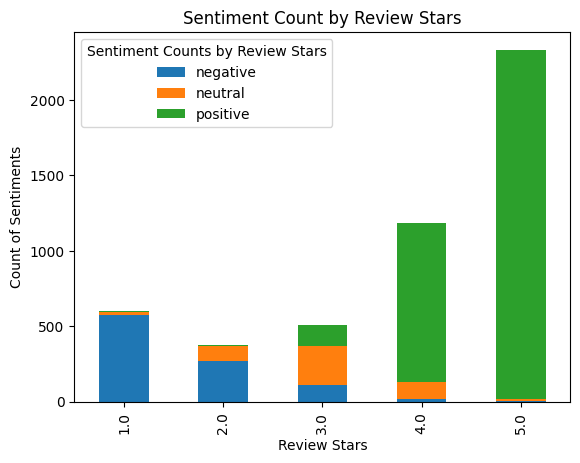

In [48]:
# Aggregate sentiments by review stars
sentiment_counts = test4.groupby(['review_stars', 'hf_sent_label']).size().reset_index(name='total_sentiment')

# Pivot the DataFrame for easier plotting
pivot_df = sentiment_counts.pivot(index='review_stars', columns='hf_sent_label', values='total_sentiment').fillna(0)

# Plotting
pivot_df.plot(kind='bar', stacked=True)
plt.title('Sentiment Count by Review Stars')
plt.xlabel('Review Stars')
plt.ylabel('Count of Sentiments')
plt.legend(title='Sentiment Counts by Review Stars')
plt.show()

This makes a lot of sense since most of the negative sentiment/blue color are in lower ratings and most of the positive sentiment/positive color are in higher ratings with neutral/orange concentrated in center of visualization: rating 3.

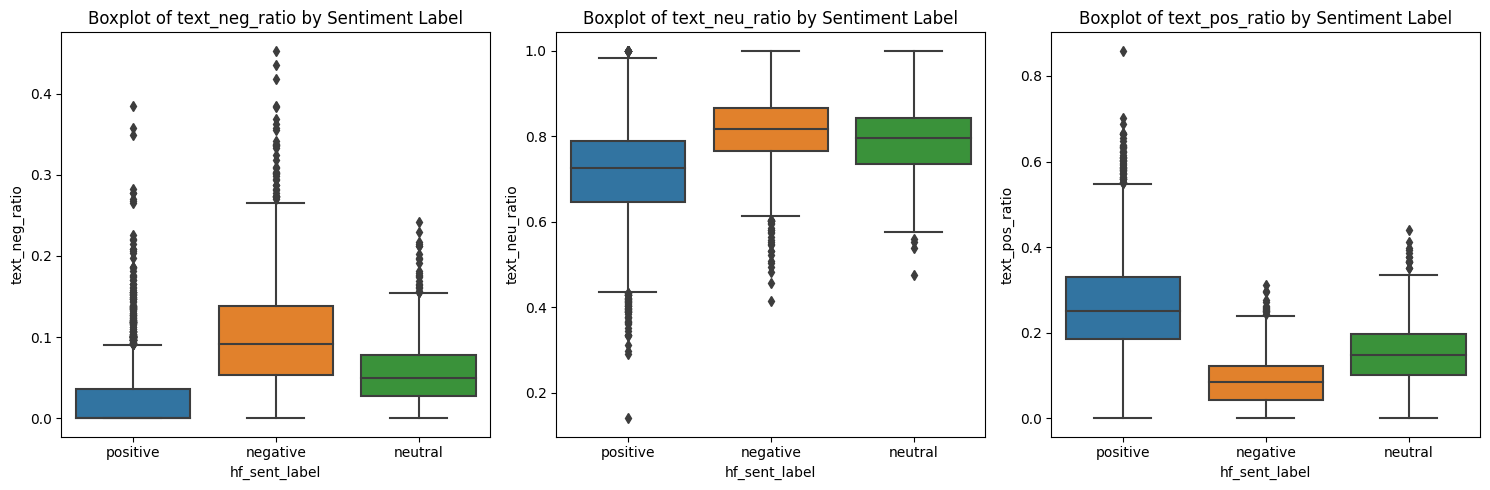

In [49]:
# Look at the box plot of sentiment ratios broken down by overall sentiment
# Plot boxplots for text_neg_ratio, text_neu_ratio, and text_pos_ratio broken down by hf_sent_label
plt.figure(figsize=(15, 5))

# Plot for text_neg_ratio
plt.subplot(1, 3, 1)
sns.boxplot(x='hf_sent_label', y='text_neg_ratio', data=test4)
plt.title('Boxplot of text_neg_ratio by Sentiment Label')

# Plot for text_neu_ratio
plt.subplot(1, 3, 2)
sns.boxplot(x='hf_sent_label', y='text_neu_ratio', data=test4)
plt.title('Boxplot of text_neu_ratio by Sentiment Label')

# Plot for text_pos_ratio
plt.subplot(1, 3, 3)
sns.boxplot(x='hf_sent_label', y='text_pos_ratio', data=test4)
plt.title('Boxplot of text_pos_ratio by Sentiment Label')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

High negative and high positive ratios correspond with neg/pos sentiments. Review sentiment composition gets murky with neutral sentiment since a neutral stance with a restaurant can have a bunch of negative or neutral comments. Would need to look at star rating to get a better view of what sentiment is majority in neutral classified reviews. Let's take a quick peek.

In [50]:
query = """
select review_stars
, clean_text
, hf_sent_label
, text_neu_ratio
, text_neg_ratio
, text_pos_ratio
from test4
where hf_sent_label = 'neutral'
"""

neutral = duckdb.query(query).df()
neutral.head(10)

,review_stars,clean_text,hf_sent_label,text_neu_ratio,text_neg_ratio,text_pos_ratio
0,3.0,"this place is just ok. the staff aren't overly friendly and the food is just mediocre. i live right down the street so it is convenient to grab an egg sandwich, but it's nothing that i couldn't make myself at home. the potatoes aren't seasoned enough and the bacon is kind of floppy. i guess you get what you pay for.",neutral,0.916,0.057,0.027
1,4.0,the tea/drinks here are pretty good. comparable to some of my favorites back in ca! the food here on the other hand is pretty mediocre. i've tried a handful of things here and they've all just been ok. but definitely would come here for the drinks.,neutral,0.709,0.000,0.291
2,2.0,"i was expecting something that would be pretty decent when i was paying $8 for a burger, taking into account that it does not come with any sides. but the first sign that i knew it wasnt going to be particularly good was that the lamb burger, despite being lamb, was cheaper than most other burgers on the menu... while the burger was hot and fresh, it took a little while to come out yet it still looked like it was simply slapped together. the toppings were scarce and only in the center of the burger, leaving half of it with just lamb patty and bun. the burger in general was simply not tasty despite the delicious sounding ingredients. overall, i might consider eating here again because of their interesting items and variety; however, if i'm looking for a burger, i would much rather go to the habit or any other burger joint even if its further away, simply because they're all either cheaper, better in quality, or both.",neutral,0.865,0.022,0.112
3,2.0,below averse tasting mexico food. menu was somewhat limited. service was fast and friendly and prices are inexpensive.,neutral,0.769,0.077,0.154
4,4.0,there were not a lot of options in ballpark village on new years day. we were trying to have lunch with my wife's sister who suggested we go here. we had trashed wings as a starter. i thought they might have all kinds of toppings. they were pretty normal except they were smoked and flash fried naked. this is my favorite way to eat wings so i was very happy. the hot sauce had a unique flavor but was only moderately hot. i would definitely get these again if i went back. we both decided on the burnt ends sandwich with beef fat fries. the burnt ends were cooked perfectly. a nice bark on the outside but tender and moist inside. the only reason for 4 stars was that the server wasn't very attentive. there were very few people there and our drinks were often empty i do not remember her ever asking how are meal was.,neutral,0.864,0.014,0.122
5,4.0,"after living in south texas for several years, i was reluctant to try mexican restaurants for fear of being sorely disappointed. that was not the case here! from the authenticity of the cuisine (with the exception of not offering barbocoa or carne guisada) to the margaritas and service... it was a little taste of my second home :)",neutral,0.818,0.135,0.047
6,5.0,"went opening day and they definitely had some kinks to work out so i returned the following week. way better. this is what you get- papaya salad (#20), khao soi chicken (35), and spicy crispy chicken basil (54, not spicy at all). also tried the pad thai and chicken wings, both of which were good but nothing unique that you couldn't get elsewhere.",neutral,0.911,0.000,0.089
7,3.0,"decided to try this place just for something new. it's a little pricey and reminds me of freddys frozen custard and steakburgers or a steak n shake. our order was correct and the food did come out hot, however i'm not sure if it's their style or maybe just a mishap but our food was very peppery. usually this doesn't bother me as i prefer to season my food with pepper but this definitely was overpowering on both the burgers and the fries. milkshake was extremely good though. if ever in the hundred oaks area i may try it again.",neutral,0.865,0.028,0.107


Text mostly is comprised of what:

0. neutral then little neg; neutral ratio correct
1. neg; wrong neg ratio
2. pos and neg (60%); wrong ratio for pos
3. pos, neutral, neg; wrong ratio for pos
4. pos, neg; pos was second
5. neg, pos; neg was low percent
6. neg, pos; neg is lowest ratio
7. pos and neg; pos is higher than neg but neu highest
8. neg, pos; pos has higher ratio than neg but neu highest
9. pos, neg; pos then neg but neu ratio is highest

Mapping review stars to sentiment is difficult because people have varying subjectve definitions for what deserves a 1 versus 5.

In [51]:
dfr.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories,review_id,user_id,review_stars,text,date
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",BXQcBN0iAi1lAUxibGLFzA,6_SpY41LIHZuIaiDs5FMKA,4.0,"This is nice little Chinese bakery in the heart of Philadelphia's Chinatown! The female cashier was very friendly (flirtatious!) and the pastries shown in nicely adorned display cases. I stopped by early one evening had a sesame ball, which was filled with bean paste. The glutinous rice of the ball was nicely flavored, similar to Bai Tang Gao. Definitely as place worth stopping at if you are in the area.",2014-05-26 01:09:53
1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",uduvUCvi9w3T2bSGivCfXg,tCXElwhzekJEH6QJe3xs7Q,4.0,"This is the bakery I usually go to in Chinatown. They have a decent variety of buns and pastries. Red bean-filled buns, mung bean-filled buns, coconut stuff, egg tarts etc. If you buy a dozen, they will give you two more for free. The prices are standard for a Chinese bakery, with most things at approximately $1. The service has always been good. They do serve coffee and tea. There are a couple of tables inside, with usually the expected group of older Chinese guys chillin' in the corner table debating about something. Great place to stock up on the buns, which I usually do before leaving town.",2013-10-05 15:19:06
2,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",a0vwPOqDXXZuJkbBW2356g,WqfKtI-aGMmvbA9pPUxNQQ,5.0,"A delightful find in Chinatown! Very clean, and very kind service. Everyone always seems happy in here, and their treats are absolutely delicious. You can also get a ton of sweet treats without any judgement! They're my favorite.",2013-10-25 01:34:57
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",MKNp_CdR2k2202-c8GN5Dw,3-1va0IQfK-9tUMzfHWfTA,5.0,I ordered a graduation cake for my niece and it came out absolut

In [52]:
# Join sample table to dfr to get category and date for review

query = """
select *
from test4
inner join (select review_id as review_id, categories, date from dfr) as dfr
on test4.review_id = dfr.review_id
"""

test5 = duckdb.query(query).df()
test5.head(10)

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,text_neg_ratio,text_neu_ratio,text_pos_ratio,review_id_1,categories,date
0,IC_tOmpYU44jkdKevv2hMA,3.0,"we stopped in here for lunch on saturday. the first thing we found out is that on weekends, they only have the dinner menu. no big deal, as i was starving, but some lunch options would have been nice. we got bruschetta and calamari for appetizers. the calamari was delicious - it comes sauteed in marinara, and it was perfectly cooked and tender. my only gripe is that i expected more than what we got for $14. for lunch i got the eggplant parm. portion size was not an issue this time, as i got more than enough to fill me up. it was pretty good, but i felt the marinara sauce was mediocre at best. one person with me got spaghetti and meatballs, which he said was delicious; another got chicken caesar salad and did not like the dressing that came with it. the service was also up and down as well. our waiter was practically mumbling at the beginning of our meal, but by the end had woken up a bit. the hit or miss nature of ralph's led me to give it 3 stars. it was an overall pleasant experience, but nothing to write home about",neutral,0.537822,0.039,0.781,0.179,IC_tOmpYU44jkdKevv2hMA,"Restaurants, Italian",2014-11-02 01:05:51
1,XnS80cV7mQzFVxym9d0n2A,5.0,"my favorite part about this place...no one walks in the door without being acknowledged with a ""hello, please sit anywhere you like"". the menu has something for everyone. food was delicious and servers were friendly. would definitely come back again.",positive,0.996099,0.000,0.695,0.305,XnS80cV7mQzFVxym9d0n2A,"Restaurants, Cafes, Diners, Breakfast & Brunch, Burgers",2019-06-15 14:46:27
2,op1irme7X7Go_0Rer3RKCw,5.0,"one thing i miss about my former job, is the daily visits to mazzaro's on my lunch break. the coffee was always fresh and the prices were decent. it's an adventure for your senses, mazzaro's pretty much has a crowd whenever i go, but if you go after 3pm, mainly after the lunch crowd, you can easily find a table and it's less crowded. which is great if you only have 30 minutes, since finding a parking space was usually the main problem. i didn't shop the market as much as i would of liked, but they have an amazing selection, you can pretty much think you've seen it all, and find something new. the staff is friendly, but be ready with your order, while there's a lot of staff, due to the number of customers that are usually in line, they don't have time to wait for indecisiveness.",positive,0.916313,0.046,0.742,0.212,op1irme7X7Go_0Rer3RKCw,"Specialty Food, Delis, Coffee Roasteries, Butcher, Meat Shops, Food, Restaurants, Grocery, Italian",2014-02-26 17:47:51
3,oiQIfKQ1MvqQQwqXLy72Fg,5.0,"one of my favorite places in st pete. the market has an old-world feel and the employees are excellent. everyone knows what they are talking about and they are fun to talk to. the food served next to the deli counter is delicious and very well-priced. possibly one of the best burgers in town and definitely one of the best italian sandwiches. the market itself has above average prices but chances are you will find what you're looking for. seriously, come check this place out. it's always packed but it adds to the charm. go the last hour before closing to avoid crowds if that's not your thing",positive,0.995704,0.039,0.785,0.175,oiQIfKQ1MvqQQwqXLy72Fg,"Specialty Food, Delis, Coffee Roasteries, Butcher, Meat Shops, Food, Restaurants, Grocery, Italian",2017-08-03 18:53:19
4,_n-ai75pth29LqWSNfq6Qg,5.0,"fantastic! i have never had a bad lunch here. the chicken parmesan sandwich is killer! absolutely fantastic!! the rest of the market is phenomenal-from the bakery to the wine and cheese sections-if you want to know what a 1,100lbs mozzarella torpedo, for lack of a better word, looks like, it's worth stopping by just to see it! you will also find excellent selections in the meat department. the whole place is very rustic, you feel like

In [53]:
# top categories mentioned in reviews
test5['categories'].value_counts()

categories
Restaurants, Mexican                                                                     106
Restaurants, Pizza                                                                        81
Restaurants, Italian                                                                      56
Restaurants, Chinese                                                                      52
Restaurants, Seafood                                                                      29
                                                                                        ... 
Restaurants, Food Delivery Services, Nightlife, Cocktail Bars, Food, Tapas Bars, Bars      1
Restaurants, Food, Cafes, Coffee & Tea                                                     1
Restaurants, American (New), Soup, Cafes, Salad, Noodles                                   1
Italian, Seafood, Gluten-Free, Restaurants                                                 1
Mexican, Restaurants, Sandwiches, Latin American           

In [54]:
# Sentiment breakdown for category; only work with top 5
query = """
select *
from test5
where categories in ('Restaurants, Mexican', 'Restaurants, Pizza', 'Restaurants, Chinese', 'Restaurants, Italian', 'Restaurants, Seafood')
"""

test5 = duckdb.query(query).df()
test5.head(10)

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,text_neg_ratio,text_neu_ratio,text_pos_ratio,review_id_1,categories,date
0,IC_tOmpYU44jkdKevv2hMA,3.0,"we stopped in here for lunch on saturday. the first thing we found out is that on weekends, they only have the dinner menu. no big deal, as i was starving, but some lunch options would have been nice. we got bruschetta and calamari for appetizers. the calamari was delicious - it comes sauteed in marinara, and it was perfectly cooked and tender. my only gripe is that i expected more than what we got for $14. for lunch i got the eggplant parm. portion size was not an issue this time, as i got more than enough to fill me up. it was pretty good, but i felt the marinara sauce was mediocre at best. one person with me got spaghetti and meatballs, which he said was delicious; another got chicken caesar salad and did not like the dressing that came with it. the service was also up and down as well. our waiter was practically mumbling at the beginning of our meal, but by the end had woken up a bit. the hit or miss nature of ralph's led me to give it 3 stars. it was an overall pleasant experience, but nothing to write home about",neutral,0.537822,0.039,0.781,0.179,IC_tOmpYU44jkdKevv2hMA,"Restaurants, Italian",2014-11-02 01:05:51
1,gzAbkHCdJCfsBkZAYUWUpg,4.0,"hits the spot! i have lived all across the country and had chinese from many places. they've nailed the basic menu items and i'll start working my way through the menu in the future. so far the general tso chicken, sweet and sour chicken, beef with broccoli and won ton soup are very good.",positive,0.997158,0.000,0.831,0.169,gzAbkHCdJCfsBkZAYUWUpg,"Restaurants, Chinese",2015-06-30 20:53:59
2,0ZTRDJ4xGk4I8l4GIjqPSw,4.0,"finally got to eat here...i was worried that the portion size was going to be small, but i thought for the price, the portions were just fine. my boyfriend and i had the quattro formaggi and pancetta pizza as an appetizer and the black pasta and blueberry lasagna for entrees- both really good. not the best italian i've ever had (i like more traditional italian) but the atmosphere is amazing and for a semi-reasonable price, you get some very interesting and different tasting dishes...i will be back for sure!",positive,0.990795,0.058,0.734,0.209,0ZTRDJ4xGk4I8l4GIjqPSw,"Restaurants, Italian",2014-05-05 20:29:26
3,ZytnvqO955aOH-i1p3KPVA,1.0,"very disappointed. take out order- burnt taquitos and chicken bones in food.get all the way home and find this sh**! i know they are usually a little crispy but this was burnt to a crisp and put on a bed of dirty lettuce. then when tried to pick thru to see if any of it was edible, found big chicken bones that most likely would have caused some damage to esophagus or stomach lining.gone way down hill. tried to call and hung up on-highly do not recommend. this was the largo location.",negative,0.990867,0.137,0.863,0.000,ZytnvqO955aOH-i1p3KPVA,"Restaurants, Mexican",2021-11-03 18:45:33
4,WxgIIve8GHlstilL860R0A,1.0,"was not impressed at all, i've been to many bubba gumps and this was by far the worst experience i've had. we put our name on a wait list which seemed odd considering that 3/4 of the restaurant was empty, roughly 15 minutes or so we finally got to our table. about another 15-20 minutes went by till our waitress came by to ask what we wanted to drink, we chose water and mentioned we were ready for food. we ordered the ""shrimpers heaven"". finally got our waters and the food came about 10-15 minutes after that which seemed relatively fast. we started to eat and half the meal was cold and the other half was soggy. didn't receive any refills of water, and the waitress didn't come by to check on the meal. a gentleman came by i think it was the manager? but i don't know for sure as he didn't introduce himself asked if we needed anything else i replied with no just the bill he then left without taking anything off the table and the waitress came back 10 minutes later wi

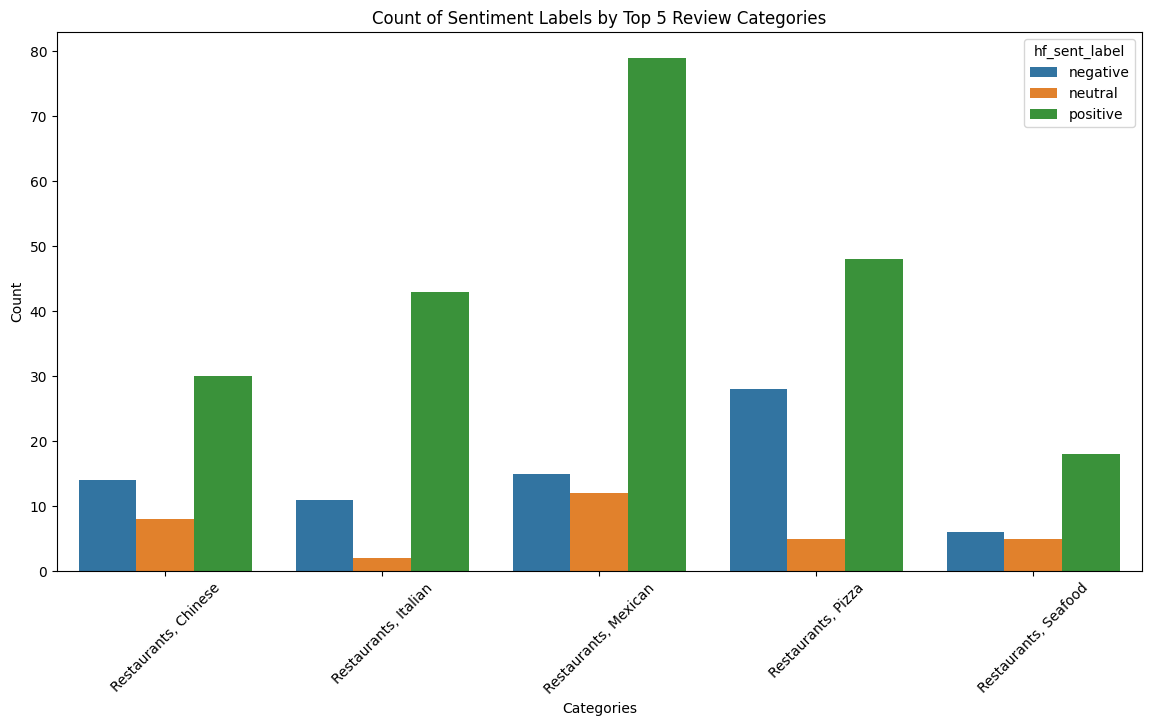

In [55]:
# Group by hf_sent_label and categories and count occurrences
df_grouped = test5.groupby(['hf_sent_label', 'categories']).size().reset_index(name='count')

# Plot the results
plt.figure(figsize=(14, 7))
sns.barplot(x='categories', y='count', hue='hf_sent_label', data=df_grouped)
plt.xticks(rotation=45)
plt.title('Count of Sentiment Labels by Top 5 Review Categories')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

For Mexican Restaurants, positive reviews far outweigh any other cateory.

/tmp/ipykernel_18/3885938236.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['date'] = pd.to_datetime(df_filtered['date'])
/tmp/ipykernel_18/3885938236.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['year_month'] = df_filtered['date'].dt.to_period('M')


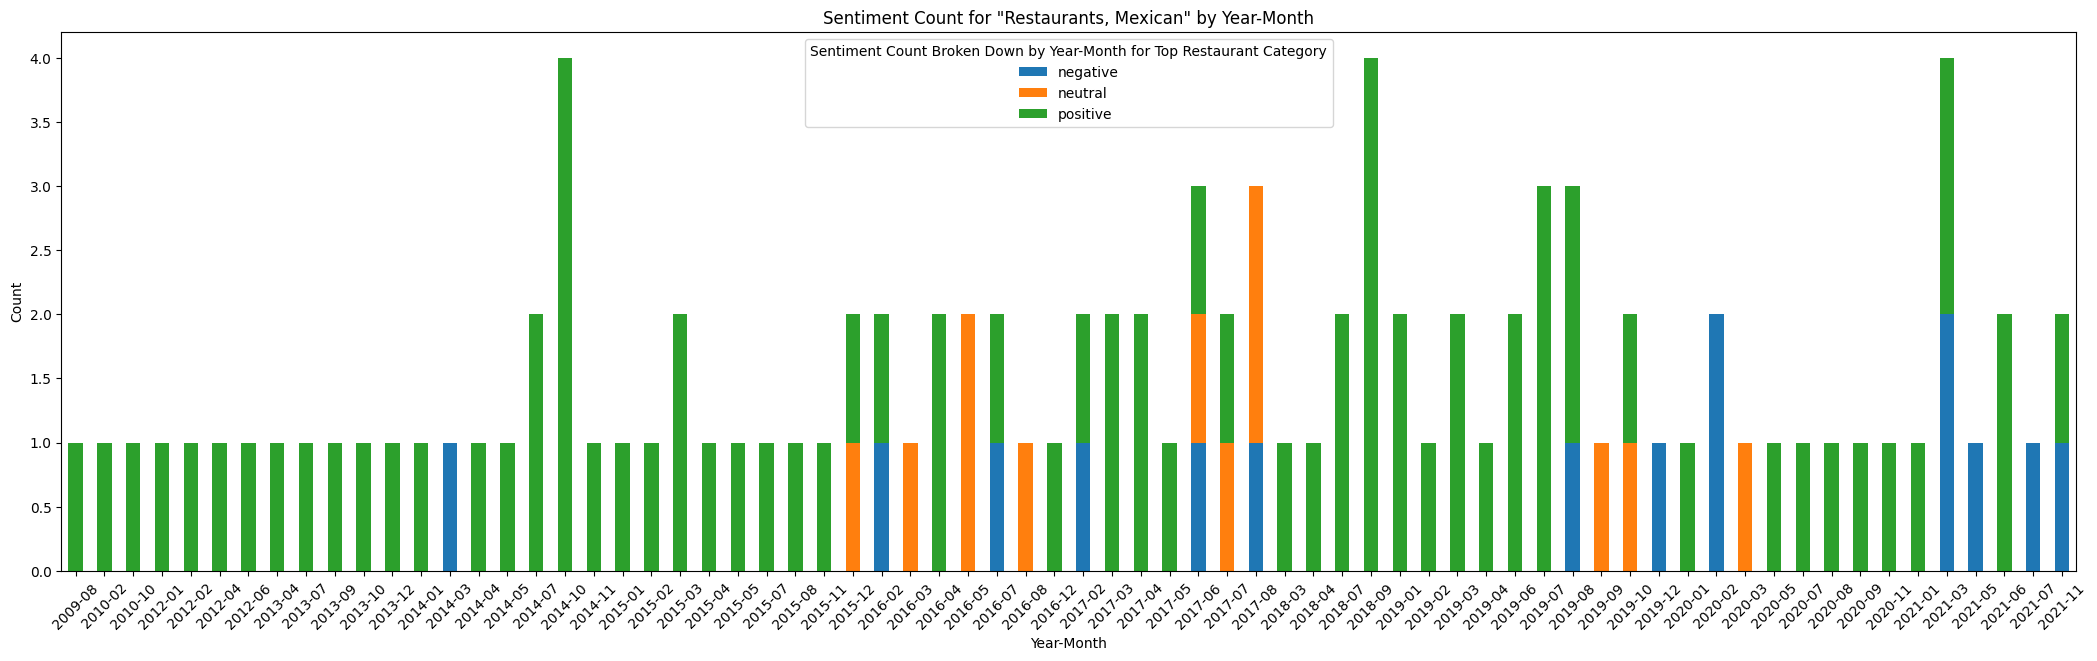

In [56]:
# Sentiment over time for top category: Restaurants, Mexican
# Filter the DataFrame to include only rows where categories is 'Restaurants, Mexican'
df_filtered = test5[test5['categories'] == 'Restaurants, Mexican']

# Convert the date column to datetime
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Extract year and month from the date column
df_filtered['year_month'] = df_filtered['date'].dt.to_period('M')

# Group by hf_sent_label and year_month and count occurrences
df_grouped = df_filtered.groupby(['hf_sent_label', 'year_month']).size().reset_index(name='count')

# Pivot the data for plotting
df_pivot = df_grouped.pivot(index='year_month', columns='hf_sent_label', values='count').fillna(0)

# Plot the results
df_pivot.plot(kind='bar', stacked=True, figsize=(26, 7))
plt.title('Sentiment Count for "Restaurants, Mexican" by Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment Count Broken Down by Year-Month for Top Restaurant Category')
plt.show()

Mexican Restaurant category did best in 2018 spring. Would be interesting to focus in on one particular business and see sentiment trend over time.

And of course we want to know what are the reasons for certain sentiments. 
First, let's look at the most talked about topics in these restaurnt reviews.

# Topic Modeling


Extensive pre-processing need to be done because topic modeling cannot interpret all the text noise as well as Hugging Face LLM's can.

In [57]:
test6 = df_filtered.copy()

In [58]:
# Expand contractions and translate common social acronyms

# Dictionary for contractions
contractions_dict = {
    "i've": "I have",
    "can't": "cannot",
    "won't": "will not",
    "i'm": "I am",
    "you're": "you are",
    "they're": "they are",
    "we're": "we are",
    "it's": "it is",
    "he's": "he is",
    "she's": "she is",
    "that's": "that is",
    "there's": "there is",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "couldn't": "could not",
    "doesn't": "does not",
    "don't": "do not",
    "didn't": "did not",
    "mustn't": "must not",
    "mightn't": "might not",
    "needn't": "need not",
    "you'd": "you would",
    "they'd": "they would",
    "we'd": "we would",
    "she'd": "she would",
    "he'd": "he would",
    "i'd": "I would",
    "it'd": "it would",
    "who'd": "who would",
    "what's": "what is",
    "how's": "how is",
    "let's": "let us",
    "here's": "here is"
}

# Dictionary for social acronyms
acronyms_dict = {
    "lol": "laugh out loud",
    "brb": "be right back",
    "gtg": "got to go",
    "idk": "I do not know",
    "imho": "in my humble opinion",
    "btw": "by the way",
    "omg": "oh my god",
    "ttyl": "talk to you later",
    "afaik": "as far as I know",
    "asap": "as soon as possible",
    "bff": "best friends forever",
    "fyi": "for your information",
    "lmk": "let me know",
    "nvm": "never mind",
    "smh": "shaking my head",
    "tbh": "to be honest",
    "wtf": "what the heck",
    "wth": "what the heck",
    "xoxo": "hugs and kisses"
}

# Combine both dictionaries
combined_dict = {**contractions_dict, **acronyms_dict}

# Function to expand contractions and acronyms
def expand_text(text):
    def replace(match):
        return combined_dict[match.group(0).lower()]

    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in combined_dict.keys()) + r')\b', re.IGNORECASE)
    expanded_text = pattern.sub(replace, text)
    return expanded_text

# Example usage
# text = "I've been busy lol. IDK what's happening, but can't wait to see you!"
# expanded_text = expand_text(text)
# print(expanded_text)

In [59]:
# given context of reviews, need to translate $ and % amounts into english

# def translate_amounts(text):
#     # Define regex patterns for dollar amounts and percentages
#     dollar_pattern = re.compile(r'\$(\d+(\.\d{1,2})?)')
#     percent_pattern = re.compile(r'(\d+(\.\d{1,2})?)%')

#     # Replace dollar amounts with "X dollars"
#     text = dollar_pattern.sub(lambda match: f"{float(match.group(1))} dollars", text)
    
#     # Replace percentages with "X percent"
#     text = percent_pattern.sub(lambda match: f"{float(match.group(1))} percent", text)
    
#     return text

# Example usage
# text = "The price is $4.00 and the discount is 4%."
# translated_text = translate_amounts(text)
# print(translated_text)  # Output: The price is 4.0 dollars and the discount is 4.0 percent.

In [60]:
# def replace_ampersand(text):
#     return text.replace('&', 'and')

# sentence = 'This is a test for &'
# print(replace_ampersand(sentence))

In [61]:
# def remove_punctuation(text):
#     return re.sub(r'[^\w\s]', '', text)

In [62]:
def more_txt_prep(text):
    # Define regex patterns for dollar amounts and percentages
    dollar_pattern = re.compile(r'\$(\d+(\.\d{1,2})?)')
    percent_pattern = re.compile(r'(\d+(\.\d{1,2})?)%')

    # Replace dollar amounts with "X dollars"
    text = dollar_pattern.sub(lambda match: f"{float(match.group(1))} dollars", text)
    
    # Replace percentages with "X percent"
    text = percent_pattern.sub(lambda match: f"{float(match.group(1))} percent", text)
    
    #replace ampersand
    text = text.replace('&', 'and')
    
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    return text

In [63]:
# Some More Text Pre-Processing: tokenize, lemmatize, remove stop words

test6['clean_text2'] = test6.apply(lambda row: expand_text(row.clean_text), axis = 1)
test6['clean_text2'] = test6.apply(lambda row: more_txt_prep(row.clean_text2), axis = 1)
test6['tokenized'] = test6.apply(lambda row: tokenizer.tokenize(row.clean_text2), axis = 1)
test6.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,text_neg_ratio,text_neu_ratio,text_pos_ratio,review_id_1,categories,date,year_month,clean_text2,tokenized
3,ZytnvqO955aOH-i1p3KPVA,1.0,"very disappointed. take out order- burnt taquitos and chicken bones in food.get all the way home and find this sh**! i know they are usually a little crispy but this was burnt to a crisp and put on a bed of dirty lettuce. then when tried to pick thru to see if any of it was edible, found big chicken bones that most likely would have caused some damage to esophagus or stomach lining.gone way down hill. tried to call and hung up on-highly do not recommend. this was the largo location.",negative,0.990867,0.137,0.863,0.000,ZytnvqO955aOH-i1p3KPVA,"Restaurants, Mexican",2021-11-03 18:45:33,2021-11,very disappointed take out order burnt taquitos and chicken bones in foodget all the way home and find this sh i know they are usually a little crispy but this was burnt to a crisp and put on a bed of dirty lettuce then when tried to pick thru to see if any of it was edible found big chicken bones that most likely would have caused some damage to esophagus or stomach lininggone way down hill tried to call and hung up onhighly do not recommend this was the largo location,"[very, disappointed, take, out, order, burnt, ta, ##qui, ##tos, and, chicken, bones, in, food, ##get, all, the, way, home, and, find, this, sh, i, know, they, are, usually, a, little, crisp, ##y, but, this, was, burnt, to, a, crisp, and, put, on, a, bed, of, dirty, let, ##tu, ##ce, then, when, tried, to, pick, thru, to, see, if, any, of, it, was, edible, found, big, chicken, bones, that, most, likely, would, have, caused, some, damage, to, es, ##op, ##ha, ##gus, or, stomach, lining, ##gon, ##e, way, down, hill, tried, to, call, and, hung, up, on, ##hi, ##gh, ##ly, do, not, ...]"
9,e5SsGW8m3_SwcFz-KcIAVA,3.0,"i give this place three stars. i stopped in for lunch. it was very clean inside. great atmosphere. service was great. a lot of people seem to enjoy it. i ordered the steak enchiladas. the food was ok. nothing special. as i said, a lot of people seemed to enjoy it.",neutral,0.838711,0.068,0.602,0.331,e5SsGW8m3_SwcFz-KcIAVA,"Restaurants, Mexican",2017-08-14 20:59:19,2017-08,i give this place three stars i stopped in for lunch it was very clean inside great atmosphere service was great a lot of people seem to enjoy it i ordered the steak enchiladas the food was ok nothing special as i said a lot of people seemed to enjoy it,"[i, give, this, place, three, stars, i, stopped, in, for, lunch, it, was, very, clean, inside, great, atmosphere, service, was, great, a, lot, of, people, seem, to, enjoy, it, i, ordered, the, steak, en, ##chi, ##lad, ##as, the, food, was, ok, nothing, special, as, i, said, a, lot, of, people, seemed, to, enjoy, it]"
15,Jp2pDIwPD-Ua5tA4-1nAwg,5.0,"wow. we went at 3pm and the line was a 30 minute wait, so go on a day that you are feeling rather patient. it is well worth the wait. i ordered the pork, peppers and tortillas combo, boyfriend got the chicken with bell pepper and onion, and we shared the quesadilla and chile relleno. the chile relleno was the special of the day and was amazing with potato, zucchini, green beans, cheese and tomato stuffed inside of a long, deep fried chile. the pork pastilla dish i got was unreal- the flavor of the pork was fantastic, and the homemade corn tortillas had the best flavor and texture i've ever had in a corn tortilla. the maza was so fresh and you can see them making the tortillas and grilling everything on the grill, which is really nice. their pico de gallo and guacamole rock. this place is out of this world and very unique style of food. i wish we would have gotten the tamale special. their mexican rice is also fabulous and not too greasy or heavy. the quesadilla was rather bland and was the one thing we probably would pass on in the future.",positive,0.985714,0.000,0.812,0.188,Jp2pDIwPD-Ua5tA4-1nAwg,"Restaurants, 

In [64]:
# Function to remove stopwords from a list of tokens
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word.lower() not in stop_words]

# Remove stop words from the 'tokens' column
test6['tokens_no_stopwords'] = test6['tokenized'].apply(remove_stopwords)

test6.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,text_neg_ratio,text_neu_ratio,text_pos_ratio,review_id_1,categories,date,year_month,clean_text2,tokenized,tokens_no_stopwords
3,ZytnvqO955aOH-i1p3KPVA,1.0,"very disappointed. take out order- burnt taquitos and chicken bones in food.get all the way home and find this sh**! i know they are usually a little crispy but this was burnt to a crisp and put on a bed of dirty lettuce. then when tried to pick thru to see if any of it was edible, found big chicken bones that most likely would have caused some damage to esophagus or stomach lining.gone way down hill. tried to call and hung up on-highly do not recommend. this was the largo location.",negative,0.990867,0.137,0.863,0.000,ZytnvqO955aOH-i1p3KPVA,"Restaurants, Mexican",2021-11-03 18:45:33,2021-11,very disappointed take out order burnt taquitos and chicken bones in foodget all the way home and find this sh i know they are usually a little crispy but this was burnt to a crisp and put on a bed of dirty lettuce then when tried to pick thru to see if any of it was edible found big chicken bones that most likely would have caused some damage to esophagus or stomach lininggone way down hill tried to call and hung up onhighly do not recommend this was the largo location,"[very, disappointed, take, out, order, burnt, ta, ##qui, ##tos, and, chicken, bones, in, food, ##get, all, the, way, home, and, find, this, sh, i, know, they, are, usually, a, little, crisp, ##y, but, this, was, burnt, to, a, crisp, and, put, on, a, bed, of, dirty, let, ##tu, ##ce, then, when, tried, to, pick, thru, to, see, if, any, of, it, was, edible, found, big, chicken, bones, that, most, likely, would, have, caused, some, damage, to, es, ##op, ##ha, ##gus, or, stomach, lining, ##gon, ##e, way, down, hill, tried, to, call, and, hung, up, on, ##hi, ##gh, ##ly, do, not, ...]","[disappointed, take, order, burnt, ta, ##qui, ##tos, chicken, bones, food, ##get, way, home, find, sh, know, usually, little, crisp, ##y, burnt, crisp, put, bed, dirty, let, ##tu, ##ce, tried, pick, thru, see, edible, found, big, chicken, bones, likely, would, caused, damage, es, ##op, ##ha, ##gus, stomach, lining, ##gon, ##e, way, hill, tried, call, hung, ##hi, ##gh, ##ly, recommend, la, ##rgo, location]"
9,e5SsGW8m3_SwcFz-KcIAVA,3.0,"i give this place three stars. i stopped in for lunch. it was very clean inside. great atmosphere. service was great. a lot of people seem to enjoy it. i ordered the steak enchiladas. the food was ok. nothing special. as i said, a lot of people seemed to enjoy it.",neutral,0.838711,0.068,0.602,0.331,e5SsGW8m3_SwcFz-KcIAVA,"Restaurants, Mexican",2017-08-14 20:59:19,2017-08,i give this place three stars i stopped in for lunch it was very clean inside great atmosphere service was great a lot of people seem to enjoy it i ordered the steak enchiladas the food was ok nothing special as i said a lot of people seemed to enjoy it,"[i, give, this, place, three, stars, i, stopped, in, for, lunch, it, was, very, clean, inside, great, atmosphere, service, was, great, a, lot, of, people, seem, to, enjoy, it, i, ordered, the, steak, en, ##chi, ##lad, ##as, the, food, was, ok, nothing, special, as, i, said, a, lot, of, people, seemed, to, enjoy, it]","[give, place, three, stars, stopped, lunch, clean, inside, great, atmosphere, service, great, lot, people, seem, enjoy, ordered, steak, en, ##chi, ##lad, ##as, food, ok, nothing, special, said, lot, people, seemed, enjoy]"
15,Jp2pDIwPD-Ua5tA4-1nAwg,5.0,"wow. we went at 3pm and the line was a 30 minute wait, so go on a day that you are feeling rather patient. it is well worth the wait. i ordered the pork, peppers and tortillas combo, boyfriend got the chicken with bell pepper and onion, and we shared the quesadilla and chile relleno. the chile relleno was the special of the day and was amazing with potato, zucchini, green beans, cheese and tomato stuffed inside of a long, deep fried chile. the pork pastilla dish i got wa

In [65]:
# Function to lemmatize a list of tokens
def lemmatize_tokens(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

# Example DataFrame
# data = {
#     'text': ["I love eating tacos.", "The taco was delicious!"],
#     'tokens': [["I", "love", "eating", "tacos"], ["The", "taco", "was", "delicious"]]
# }
# df = pd.DataFrame(data)

# Apply the lemmatization function to the 'tokens' column
test6['lemmatized_tokens'] = test6['tokens_no_stopwords'].apply(lemmatize_tokens)

# Display the DataFrame
test6.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,text_neg_ratio,text_neu_ratio,text_pos_ratio,review_id_1,categories,date,year_month,clean_text2,tokenized,tokens_no_stopwords,lemmatized_tokens
3,ZytnvqO955aOH-i1p3KPVA,1.0,"very disappointed. take out order- burnt taquitos and chicken bones in food.get all the way home and find this sh**! i know they are usually a little crispy but this was burnt to a crisp and put on a bed of dirty lettuce. then when tried to pick thru to see if any of it was edible, found big chicken bones that most likely would have caused some damage to esophagus or stomach lining.gone way down hill. tried to call and hung up on-highly do not recommend. this was the largo location.",negative,0.990867,0.137,0.863,0.000,ZytnvqO955aOH-i1p3KPVA,"Restaurants, Mexican",2021-11-03 18:45:33,2021-11,very disappointed take out order burnt taquitos and chicken bones in foodget all the way home and find this sh i know they are usually a little crispy but this was burnt to a crisp and put on a bed of dirty lettuce then when tried to pick thru to see if any of it was edible found big chicken bones that most likely would have caused some damage to esophagus or stomach lininggone way down hill tried to call and hung up onhighly do not recommend this was the largo location,"[very, disappointed, take, out, order, burnt, ta, ##qui, ##tos, and, chicken, bones, in, food, ##get, all, the, way, home, and, find, this, sh, i, know, they, are, usually, a, little, crisp, ##y, but, this, was, burnt, to, a, crisp, and, put, on, a, bed, of, dirty, let, ##tu, ##ce, then, when, tried, to, pick, thru, to, see, if, any, of, it, was, edible, found, big, chicken, bones, that, most, likely, would, have, caused, some, damage, to, es, ##op, ##ha, ##gus, or, stomach, lining, ##gon, ##e, way, down, hill, tried, to, call, and, hung, up, on, ##hi, ##gh, ##ly, do, not, ...]","[disappointed, take, order, burnt, ta, ##qui, ##tos, chicken, bones, food, ##get, way, home, find, sh, know, usually, little, crisp, ##y, burnt, crisp, put, bed, dirty, let, ##tu, ##ce, tried, pick, thru, see, edible, found, big, chicken, bones, likely, would, caused, damage, es, ##op, ##ha, ##gus, stomach, lining, ##gon, ##e, way, hill, tried, call, hung, ##hi, ##gh, ##ly, recommend, la, ##rgo, location]","[disappointed, take, order, burn, ta, #, #, qui, #, #, to, chicken, bone, food, #, #, get, way, home, find, sh, know, usually, little, crisp, #, #, y, burn, crisp, put, bed, dirty, let, #, #, tu, #, #, ce, try, pick, thru, see, edible, find, big, chicken, bone, likely, would, cause, damage, es, #, #, op, #, #, ha, #, #, gus, stomach, line, #, #, gon, #, #, e, way, hill, tried, call, hang, #, #, hi, #, #, gh, #, #, ly, recommend, la, #, #, rgo, location]"
9,e5SsGW8m3_SwcFz-KcIAVA,3.0,"i give this place three stars. i stopped in for lunch. it was very clean inside. great atmosphere. service was great. a lot of people seem to enjoy it. i ordered the steak enchiladas. the food was ok. nothing special. as i said, a lot of people seemed to enjoy it.",neutral,0.838711,0.068,0.602,0.331,e5SsGW8m3_SwcFz-KcIAVA,"Restaurants, Mexican",2017-08-14 20:59:19,2017-08,i give this place three stars i stopped in for lunch it was very clean inside great atmosphere service was great a lot of people seem to enjoy it i ordered the steak enchiladas the food was ok nothing special as i said a lot of people seemed to enjoy it,"[i, give, this, place, three, stars, i, stopped, in, for, lunch, it, was, very, clean, inside, great, atmosphere, service, was, great, a, lot, of, people, seem, to, enjoy, it, i, ordered, the, steak, en, ##chi, ##lad, ##as, the, food, was, ok, nothing, special, as, i, said, a, lot, of, people, seemed, to, enjoy, it]","[give, place, three, stars, stopped, lunch, clean, inside, great, atmosphere, service, great, lot, people, seem, enjoy, ordered, steak, en, ##chi, ##lad, ##as, food, ok, nothing, special, said, lot, people, seemed, enjoy]","[give, place, three, star, 

In [66]:
# turn cleaned up text column back to strings only

# Function to join list of strings into a single string
def list_to_string(list_of_strings):
    text = ' '.join(list_of_strings)
    return re.sub(r'[^\w\s]', '', text)  # remove punctuation again...

    
test6['clean_text3'] = test6['lemmatized_tokens'].apply(list_to_string)

# Display the DataFrame
test6.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,text_neg_ratio,text_neu_ratio,text_pos_ratio,review_id_1,categories,date,year_month,clean_text2,tokenized,tokens_no_stopwords,lemmatized_tokens,clean_text3
3,ZytnvqO955aOH-i1p3KPVA,1.0,"very disappointed. take out order- burnt taquitos and chicken bones in food.get all the way home and find this sh**! i know they are usually a little crispy but this was burnt to a crisp and put on a bed of dirty lettuce. then when tried to pick thru to see if any of it was edible, found big chicken bones that most likely would have caused some damage to esophagus or stomach lining.gone way down hill. tried to call and hung up on-highly do not recommend. this was the largo location.",negative,0.990867,0.137,0.863,0.000,ZytnvqO955aOH-i1p3KPVA,"Restaurants, Mexican",2021-11-03 18:45:33,2021-11,very disappointed take out order burnt taquitos and chicken bones in foodget all the way home and find this sh i know they are usually a little crispy but this was burnt to a crisp and put on a bed of dirty lettuce then when tried to pick thru to see if any of it was edible found big chicken bones that most likely would have caused some damage to esophagus or stomach lininggone way down hill tried to call and hung up onhighly do not recommend this was the largo location,"[very, disappointed, take, out, order, burnt, ta, ##qui, ##tos, and, chicken, bones, in, food, ##get, all, the, way, home, and, find, this, sh, i, know, they, are, usually, a, little, crisp, ##y, but, this, was, burnt, to, a, crisp, and, put, on, a, bed, of, dirty, let, ##tu, ##ce, then, when, tried, to, pick, thru, to, see, if, any, of, it, was, edible, found, big, chicken, bones, that, most, likely, would, have, caused, some, damage, to, es, ##op, ##ha, ##gus, or, stomach, lining, ##gon, ##e, way, down, hill, tried, to, call, and, hung, up, on, ##hi, ##gh, ##ly, do, not, ...]","[disappointed, take, order, burnt, ta, ##qui, ##tos, chicken, bones, food, ##get, way, home, find, sh, know, usually, little, crisp, ##y, burnt, crisp, put, bed, dirty, let, ##tu, ##ce, tried, pick, thru, see, edible, found, big, chicken, bones, likely, would, caused, damage, es, ##op, ##ha, ##gus, stomach, lining, ##gon, ##e, way, hill, tried, call, hung, ##hi, ##gh, ##ly, recommend, la, ##rgo, location]","[disappointed, take, order, burn, ta, #, #, qui, #, #, to, chicken, bone, food, #, #, get, way, home, find, sh, know, usually, little, crisp, #, #, y, burn, crisp, put, bed, dirty, let, #, #, tu, #, #, ce, try, pick, thru, see, edible, find, big, chicken, bone, likely, would, cause, damage, es, #, #, op, #, #, ha, #, #, gus, stomach, line, #, #, gon, #, #, e, way, hill, tried, call, hang, #, #, hi, #, #, gh, #, #, ly, recommend, la, #, #, rgo, location]",disappointed take order burn ta qui to chicken bone food get way home find sh know usually little crisp y burn crisp put bed dirty let tu ce try pick thru see edible find big chicken bone likely would cause damage es op ha gus stomach line gon e way hill tried call hang hi gh ly recommend la rgo location
9,e5SsGW8m3_SwcFz-KcIAVA,3.0,"i give this place three stars. i stopped in for lunch. it was very clean inside. great atmosphere. service was great. a lot of people seem to enjoy it. i ordered the steak enchiladas. the food was ok. nothing special. as i said, a lot of people seemed to enjoy it.",neutral,0.838711,0.068,0.602,0.331,e5SsGW8m3_SwcFz-KcIAVA,"Restaurants, Mexican",2017-08-14 20:59:19,2017-08,i give this place three stars i stopped in for lunch it was very clean inside great atmosphere service was great a lot of people seem to enjoy it i ordered the steak enchiladas the food was ok nothing special as i said a lot of people seemed to enjoy it,"[i, give, this, place, three, stars, i, stopped, in, for, lunch, it, was, very, clean, inside, great, atmosphere, service, was, great, a, lot, of, people, seem, to, enjoy, it, i, ordered, the, steak, en, ##chi, ##lad, ##as, the, food, was, ok, nothing, 

In [67]:
# Now trying topic modeling with cleaned text!
reindexed_data = test6['clean_text3']
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english') + ['food', 'ta', 'take'], use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)

In [68]:
n_topics = 6
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [69]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [70]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [71]:
def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

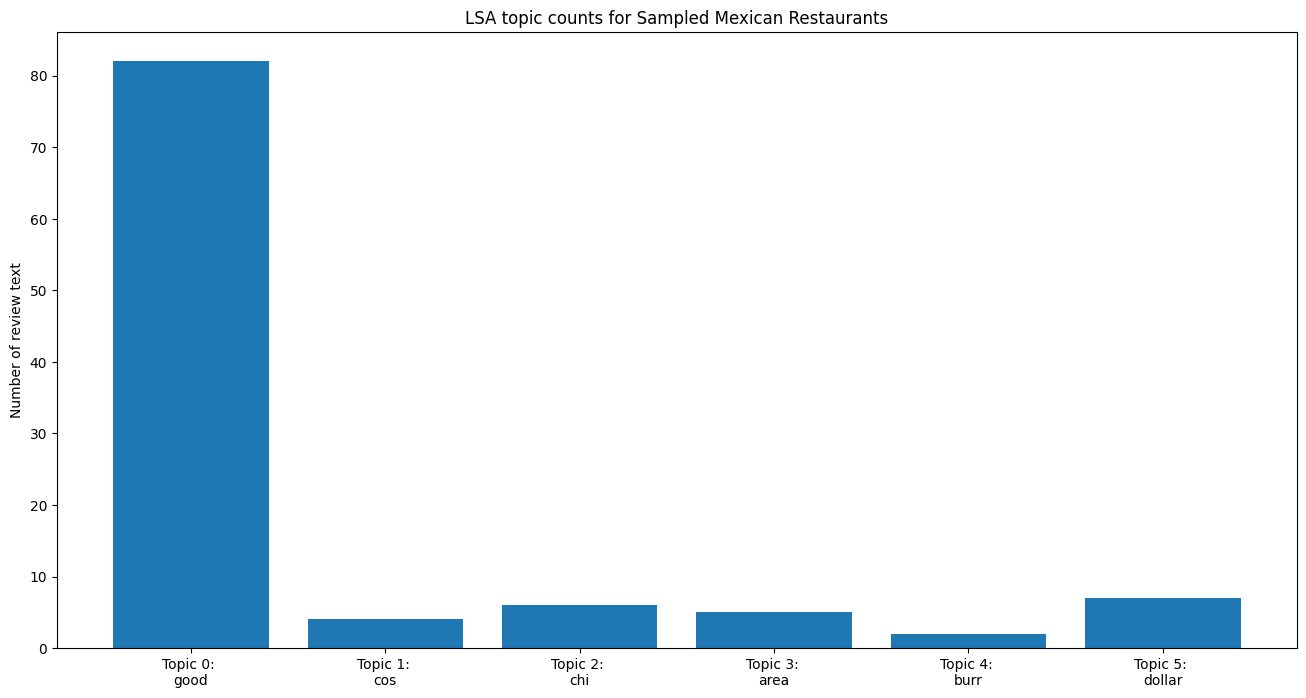

In [72]:
top_3_words = get_top_n_words(1, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of review text');
ax.set_title('LSA topic counts for Sampled Mexican Restaurants');
plt.show();

# Aspect Extraction: What is being talked about in the reviews? - Topics at a more granular level

# Aspect-based opinion mining

In [73]:
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# tokenizer = AutoTokenizer.from_pretrained("NUSTM/restaurant-t5-base")
# model = AutoModelForSeq2SeqLM.from_pretrained("NUSTM/restaurant-t5-base")

# input_ids = tokenizer(
#    "The pizza here is delicious!!", return_tensors="pt"
# ).input_ids  # Batch size 1
# outputs = model(input_ids=input_ids)